In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot, graphviz
import os
import re
from datetime import datetime, date
import math

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
telecom_df_base=pd.read_csv('telecom_churn_data.csv', encoding='ISO-8859-1')

In [3]:
telecom_plot_base=telecom_df_base.reset_index()
master_df=telecom_df_base.copy()
print(telecom_df_base.shape)

(99999, 226)


### Utilities Method

In [4]:
### Null estimator Graph
def null_na_estimator_grph(data_f,limit_val=None,graphical=False,size=(None,None)):
    """will return the % amount of null in data frame
       df: panda.DataFrame
       limit_val= (default=None) threshold value, example if limit_val=7, the estimator will return na with >=7
    """
    df=data_f.copy()
    est_ser=est_ser= (round(df.isnull().sum()/len(df.index)*100,2)).sort_values(ascending=False)
    if limit_val!=None:
        est_ser= est_ser[est_ser>=limit_val]
    if graphical==True:
        df=pd.DataFrame(est_ser).reset_index()
        plt.figure(figsize=size)
        plt.xticks(rotation=90)
        fig=sns.barplot(data=df,x='index',y=0)
        fig.set_ylabel('Percentage')
        return fig
    else:
        return est_ser

In [5]:
def data_set_structure(df,return_tuple=False):
    """It will return the structure of dataframe or columns tuple as list
    out: tuple (non-num,num,month_6,month_7,month_8,month_9)
       : datafram ->structuring the complete dataset bifurcation
    """
    df_col=df.columns
    if len(df.describe().columns)!=len(df_col):
        non_num_col=df.describe(include=['object']).columns
    else:
        non_num_col=pd.Index([])
    num_col=df_col.difference(non_num_col)
    data_col_month=[x for x in df_col if re.search('_[0-9]$',x)!=None]
    col_9=[x for x in df_col if re.search('_9',x)!=None]
    col_8=[x for x in df_col if re.search('_8',x)!=None]
    col_7=[x for x in df_col if re.search('_7',x)!=None]
    col_6=[x for x in df_col if re.search('_6',x)!=None]
    col_9_n=[x for x in num_col if re.search('_9',x)!=None]
    col_8_n=[x for x in num_col if re.search('_8',x)!=None]
    col_7_n=[x for x in num_col if re.search('_7',x)!=None]
    col_6_n=[x for x in num_col if re.search('_6',x)!=None]
    
    if return_tuple==True:
        return non_num_col.tolist(),num_col.tolist(),col_6,col_7,col_8,col_9
    else:
        result=pd.DataFrame({'Month 6':[abs(len(col_6_n)-len(col_6)),len(col_6_n)],
                             'Month 7':[abs(len(col_7_n)-len(col_7)),len(col_7_n)],
                             'Month 8':[abs(len(col_8_n)-len(col_8)),len(col_8_n)],
                             'Month 9':[abs(len(col_9_n)-len(col_9)),len(col_9_n)]
                    },index=['Non-Numeric','Numeric'])
        result['Common']=[len(non_num_col)-(result.loc['Non-Numeric'].sum()),len(num_col)-(result.iloc[1,:].sum())]
        result['Total']=[result.loc['Non-Numeric'].sum(),result.loc['Numeric'].sum()]
        return result

In [6]:
def data_loss(df_old,df_new):
    """will be calculating the data loss been made in the dataframe"""
    df=pd.DataFrame({'Col loss':round(100*((len(df_old.columns)-len(df_new.columns))/len(df_old.columns)),2),
                    'Row loss':round(100*((len(df_old.index)-len(df_new.index))/len(df_old.index)),2),
                    'Data Retained':round(100*(len(df_new.columns)*len(df_new.index))/(len(df_old.columns)*len(df_old.index)),2)},index=['Percentage'])
    return df

In [7]:
def val_variance_estimator(dataFrame,graphical=False,size=(None,None),graph_filter_limit_max=0):
    variance_graph={}
    for i in range(0,len(dataFrame.columns)):
        variance_graph[dataFrame.columns[i]]=len(dataFrame.loc[:,dataFrame.columns[i]].unique())
    variance_graph_df=pd.DataFrame({'var':list(variance_graph.keys()),'count':list(variance_graph.values())})
    if graphical==True:
        plt.figure(figsize=size)
        plt.xticks(rotation=90)
        text_title='Value Variance Graph < '+str(graph_filter_limit_max)
        plt.title(text_title)
        fig=sns.barplot(x='var',y='count',data=variance_graph_df[variance_graph_df['count']<graph_filter_limit_max].sort_values(by='count',ascending=True))
        return fig
    else:
        return variance_graph_df

### EDA

##### An overview of data points and it's shape

In [8]:
print(telecom_df_base.info())
telecom_df_base.iloc[:,1:20].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76
2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36
3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68
4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26


#### Review and fix structural error

##### Correcting naming convention for some columns

In [9]:
telecom_df_base.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'},inplace=True)
telecom_df_base[['vbc_3g_6','vbc_3g_7','vbc_3g_8','vbc_3g_9']].head()

,vbc_3g_6,vbc_3g_7,vbc_3g_8,vbc_3g_9
0,101.20,0.0,30.4,3.58
1,0.00,0.0,0.0,0.00
2,4.17,0.0,0.0,0.00
3,0.00,0.0,0.0,0.00
4,0.00,0.0,0.0,0.00


In [10]:
non_num_col,num_col,col_6,col_7,col_8,col_9=data_set_structure(telecom_df_base,return_tuple=True)
data_set_structure(telecom_df_base).head()

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,3,3,3,3,0,12
Numeric,52,52,52,52,6,214


#### Exploring null/na in data set

##### Exploring data points variance

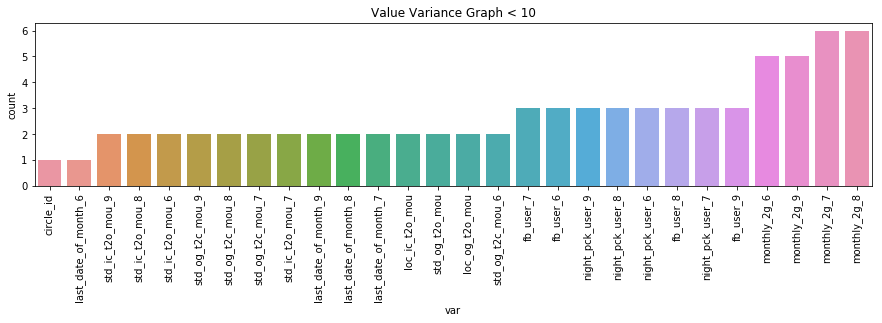

In [11]:
variance_graph_df=val_variance_estimator(telecom_df_base)
val_variance_estimator(telecom_df_base,True,(15,3),graph_filter_limit_max=10)

##### Dropping columns not having much information to add to analysis

In [12]:
#Revisiting the data which don't have variance equal to 1 or 2
variance_graph_df[variance_graph_df['count']<=2]['var']
for i in variance_graph_df[variance_graph_df['count']<=2]['var']:
    print(i," :",telecom_df_base.loc[:,i].unique())
drop_col=list(variance_graph_df[variance_graph_df['count']<=2]['var'])
#Dropping columns with just 2 values
print("As the value of these columns just have 2 values, which is not adding any information, we are going to drop them. As imputing them doesn't make sense")
####Columns = drop_col was getting an error for me so changed it to axis = 1 
telecom_df_base.drop(drop_col,axis = 1, inplace=True)

circle_id  : [109]
loc_og_t2o_mou  : [ 0. nan]
std_og_t2o_mou  : [ 0. nan]
loc_ic_t2o_mou  : [ 0. nan]
last_date_of_month_6  : ['6/30/2014']
last_date_of_month_7  : ['7/31/2014' nan]
last_date_of_month_8  : ['8/31/2014' nan]
last_date_of_month_9  : ['9/30/2014' nan]
std_og_t2c_mou_6  : [nan  0.]
std_og_t2c_mou_7  : [nan  0.]
std_og_t2c_mou_8  : [ 0. nan]
std_og_t2c_mou_9  : [nan  0.]
std_ic_t2o_mou_6  : [nan  0.]
std_ic_t2o_mou_7  : [nan  0.]
std_ic_t2o_mou_8  : [ 0. nan]
std_ic_t2o_mou_9  : [nan  0.]
As the value of these columns just have 2 values, which is not adding any information, we are going to drop them. As imputing them doesn't make sense


In [13]:
print(data_loss(master_df,telecom_df_base))
data_set_structure(telecom_df_base).head()

            Col loss  Data Retained  Row loss
Percentage      7.08          92.92       0.0


,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,2,2,2,2,0,8
Numeric,50,50,50,50,2,202


##### Checking null or na

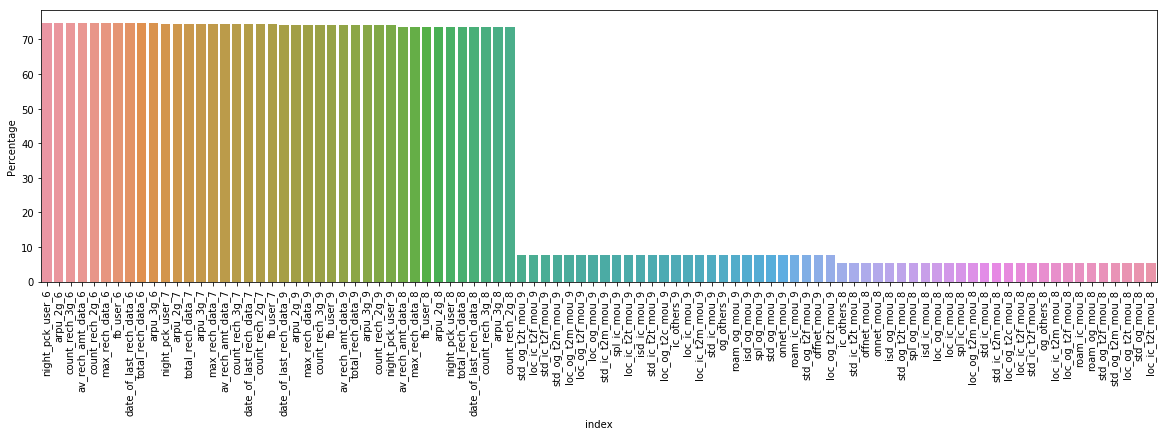

In [14]:
null_na_estimator_grph(telecom_df_base,5,graphical=True,size=(20,5))

In [15]:
plt.show()

##### Imputing features important of modeling

In [16]:
#As some columns will be used in analysis and the value range is only between 0,1,na, we are going to impute them with a new class i.e. -1 for na

for i in variance_graph_df.loc[(variance_graph_df['count']==3)]['var']:
    print(i," :",telecom_df_base.loc[:,i].unique())
impute_col=list(variance_graph_df[variance_graph_df['count']==3]['var'])

print("Imputing a new category of -1 reprsenting a miss: ",impute_col)

telecom_df_base[impute_col]=telecom_df_base[impute_col].fillna(-1)
impute_col=['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9',
            'total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
            'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9']

print("Imputing 0 for missing values: ",impute_col)
telecom_df_base[impute_col]=telecom_df_base[impute_col].fillna(0)

night_pck_user_6  : [ 0. nan  1.]
night_pck_user_7  : [ 0. nan  1.]
night_pck_user_8  : [ 0. nan  1.]
night_pck_user_9  : [nan  0.  1.]
fb_user_6  : [ 1. nan  0.]
fb_user_7  : [ 1. nan  0.]
fb_user_8  : [ 1. nan  0.]
fb_user_9  : [nan  1.  0.]
Imputing a new category of -1 reprsenting a miss:  ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']
Imputing 0 for missing values:  ['av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9']


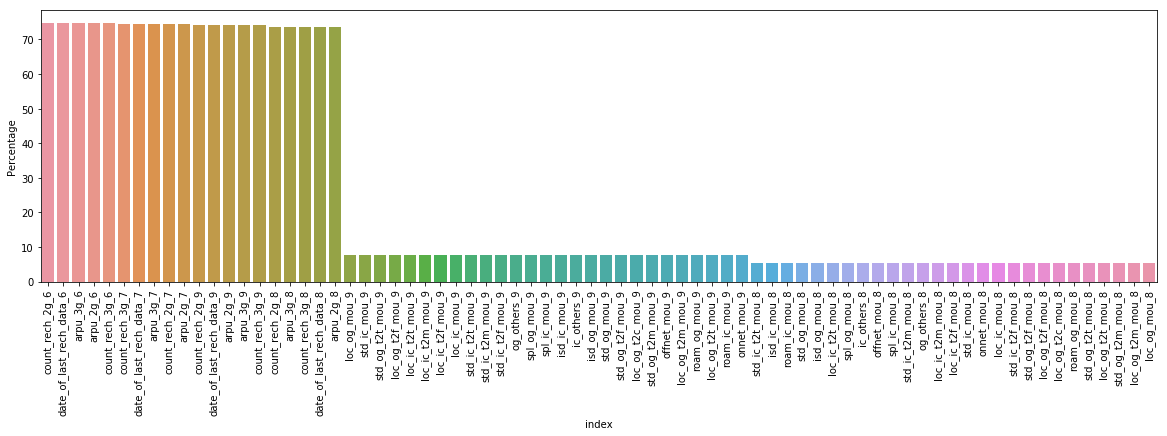

In [17]:
null_na_estimator_grph(telecom_df_base,5,graphical=True,size=(20,5))
plt.show()

In [18]:
telecom_df_base[impute_col].head()

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9
0,252.0,252.0,252.0,0.0,1.0,1.0,1.0,0.0,252.0,252.0,252.0,0.0
1,0.0,154.0,50.0,0.0,0.0,1.0,2.0,0.0,0.0,154.0,25.0,0.0
2,0.0,0.0,0.0,46.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,46.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0


##### Creating High value customer filter set

In [19]:
###Filtered data needs to be only for the first two months (The Good Months)
##Changed the Code below

In [20]:
telecom_df_base['tot_rech_amt_data_6'] = (telecom_df_base["av_rech_amt_data_6"] * telecom_df_base["total_rech_data_6"])
telecom_df_base['tot_rech_amt_data_7'] = (telecom_df_base["av_rech_amt_data_7"] * telecom_df_base["total_rech_data_7"])

In [21]:
hv_filter_col=['total_rech_amt_6','tot_rech_amt_data_6','total_rech_amt_7','tot_rech_amt_data_7']
#hv_filter_col=['total_rech_amt_6','total_rech_data_6','total_rech_num_6','total_rech_num_7','total_rech_amt_7','total_rech_data_7','total_rech_num_8','total_rech_amt_8','total_rech_data_8','total_rech_num_9','total_rech_amt_9','total_rech_data_9']
print("PRE-Computation: analysis for na/null\n",telecom_df_base[hv_filter_col].isnull().sum())

PRE-Computation: analysis for na/null
 total_rech_amt_6       0
tot_rech_amt_data_6    0
total_rech_amt_7       0
tot_rech_amt_data_7    0
dtype: int64


##### Filtering high value customers data

In [22]:
telecom_df_base['hvc'] = telecom_df_base.tot_rech_amt_data_6 + telecom_df_base.tot_rech_amt_data_7 + telecom_df_base.total_rech_amt_6+telecom_df_base.total_rech_amt_7
telecom_df_base = telecom_df_base.loc[telecom_df_base['hvc'] >= (telecom_df_base['hvc'].quantile(0.7)),:]
telecom_df_base.drop(['hvc','tot_rech_amt_data_6','tot_rech_amt_data_7'] , axis = 1 , inplace = True)

##### Converting churn=1 not-churn=0

In [23]:
telecom_df_base['churn']=(telecom_df_base['total_ic_mou_9']+telecom_df_base['total_og_mou_9'] == 0) & (telecom_df_base['vol_2g_mb_9']+telecom_df_base['vol_3g_mb_9'] == 0)
telecom_df_base.loc[:,'churn'].replace({True:1,False:0},inplace=True)

In [24]:
telecom_df_base.churn.value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [25]:
### Please double cHeck Churns but Mine seems to be coming closer to the expected Ranges too [5 - 10%]
2441/(2590+27560)*100   

8.096185737976782

#### Dropping all Coloumns with 9 in them 

In [26]:
cols_to_be_dropped = []
for cols in telecom_df_base.columns:
    if cols.endswith('9'):
        cols_to_be_dropped.append(cols)
        
telecom_df_base.drop(cols_to_be_dropped,axis=1,inplace=True) 

## Tackling NA and Possible Imputations ---- vs 0

In [27]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:10]

date_of_last_rech_data_8    46.83
count_rech_3g_8             46.83
arpu_3g_8                   46.83
arpu_2g_8                   46.83
count_rech_2g_8             46.83
date_of_last_rech_data_6    44.15
arpu_3g_6                   44.15
arpu_2g_6                   44.15
count_rech_3g_6             44.15
count_rech_2g_6             44.15
dtype: float64

In [28]:
##Tackling Data Recharge Values Data in Month 6 .
col = ['count_rech_2g_6','count_rech_3g_6' , 'arpu_2g_6', 'arpu_3g_6','date_of_last_rech_data_6']
col1 = ['total_rech_data_6','max_rech_data_6']
###Checking if its na for same 
print(telecom_df_base[col].isnull().any(axis = 1).sum()  == telecom_df_base[col].isnull().all(axis = 1).sum())  
##Checking the max and min values
print(telecom_df_base.loc[telecom_df_base[col].isnull().any(axis = 1),col1].apply(lambda x : (min(x),max(x))))

True
total_rech_data_6    (0.0, 0.0)
max_rech_data_6      (0.0, 0.0)
dtype: object


#####  As the Recharge Values total and max are 0 . It can be safely assumed that all NA's are infact 0 values . Notice it is true for date : The date is NA whenever no recharge happens . This could be used later while imputing datecoloumns .

In [29]:
col = ['count_rech_2g_6','count_rech_3g_6' , 'arpu_2g_6', 'arpu_3g_6']
telecom_df_base[col] = telecom_df_base[col].fillna(value = 0)

In [30]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:10]

count_rech_3g_8             46.83
arpu_3g_8                   46.83
arpu_2g_8                   46.83
count_rech_2g_8             46.83
date_of_last_rech_data_8    46.83
date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
arpu_3g_7                   43.15
count_rech_3g_7             43.15
arpu_2g_7                   43.15
dtype: float64

In [31]:
##Tackling Data Recharge Values Data in Month 7 .
col = ['count_rech_2g_7','count_rech_3g_7' , 'arpu_2g_7', 'arpu_3g_7','date_of_last_rech_data_7']
col1 = ['total_rech_data_7','max_rech_data_7']
###Checking if its na for same 
print(telecom_df_base[col].isnull().any(axis = 1).sum()  == telecom_df_base[col].isnull().all(axis = 1).sum())  
##Checking the max and min values
print(telecom_df_base.loc[telecom_df_base[col].isnull().any(axis = 1),col1].apply(lambda x : (min(x),max(x))))

True
total_rech_data_7    (0.0, 0.0)
max_rech_data_7      (0.0, 0.0)
dtype: object


##### As the Recharge Values total and max are 0 . It can be safely assumed that all NA's are infact 0 values . Notice it is true for date : The date is NA whenever no recharge happens . This could be used later while imputing datecoloumns 

In [32]:
col = ['count_rech_2g_7','count_rech_3g_7' , 'arpu_2g_7', 'arpu_3g_7']
telecom_df_base[col] = telecom_df_base[col].fillna(value = 0)

In [33]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:10]

count_rech_3g_8             46.83
count_rech_2g_8             46.83
arpu_2g_8                   46.83
arpu_3g_8                   46.83
date_of_last_rech_data_8    46.83
date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
loc_og_t2c_mou_8             3.91
std_ic_t2m_mou_8             3.91
std_og_t2t_mou_8             3.91
dtype: float64

In [34]:
##Tackling Data Recharge Values Data in Month 8 .
col = ['count_rech_2g_8','count_rech_3g_8' , 'arpu_2g_8', 'arpu_3g_8','date_of_last_rech_data_8']
col1 = ['total_rech_data_8','max_rech_data_8']
###Checking if its na for same 
print(telecom_df_base[col].isnull().any(axis = 1).sum()  == telecom_df_base[col].isnull().all(axis = 1).sum())  
##Checking the max and min values
print(telecom_df_base.loc[telecom_df_base[col].isnull().any(axis = 1),col1].apply(lambda x : (min(x),max(x))))

True
total_rech_data_8    (0.0, 0.0)
max_rech_data_8      (0.0, 0.0)
dtype: object


##### As the Recharge Values total and max are 0 . It can be safely assumed that all NA's are infact 0 values . Notice it is true for date : The date is NA whenever no recharge happens . This could be used later while imputing datecoloumns 

In [35]:
col = ['count_rech_2g_8','count_rech_3g_8' , 'arpu_2g_8', 'arpu_3g_8']
telecom_df_base[col] = telecom_df_base[col].fillna(value = 0)

In [36]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:40]

date_of_last_rech_data_8    46.83
date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
loc_og_t2c_mou_8             3.91
loc_og_t2m_mou_8             3.91
std_ic_t2f_mou_8             3.91
loc_og_t2f_mou_8             3.91
spl_og_mou_8                 3.91
isd_og_mou_8                 3.91
loc_og_t2t_mou_8             3.91
loc_og_mou_8                 3.91
loc_ic_t2m_mou_8             3.91
std_og_t2t_mou_8             3.91
std_og_mou_8                 3.91
loc_ic_t2f_mou_8             3.91
std_og_t2m_mou_8             3.91
std_og_t2f_mou_8             3.91
std_ic_mou_8                 3.91
roam_og_mou_8                3.91
std_ic_t2m_mou_8             3.91
og_others_8                  3.91
roam_ic_mou_8                3.91
offnet_mou_8                 3.91
loc_ic_mou_8                 3.91
isd_ic_mou_8                 3.91
spl_ic_mou_8                 3.91
loc_ic_t2t_mou_8             3.91
onnet_mou_8                  3.91
ic_others_8                  3.91
std_ic_t2t_mou

In [37]:
###Tackling Null Values in Total Outgoing and Incoming Calls Minutes in Month 8 
col = list(a[a == a['loc_og_t2c_mou_8']].index)
np.array(col)

array(['loc_og_t2c_mou_8', 'loc_og_t2m_mou_8', 'std_ic_t2f_mou_8',
       'loc_og_t2f_mou_8', 'spl_og_mou_8', 'isd_og_mou_8',
       'loc_og_t2t_mou_8', 'loc_og_mou_8', 'loc_ic_t2m_mou_8',
       'std_og_t2t_mou_8', 'std_og_mou_8', 'loc_ic_t2f_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_ic_mou_8',
       'roam_og_mou_8', 'std_ic_t2m_mou_8', 'og_others_8',
       'roam_ic_mou_8', 'offnet_mou_8', 'loc_ic_mou_8', 'isd_ic_mou_8',
       'spl_ic_mou_8', 'loc_ic_t2t_mou_8', 'onnet_mou_8', 'ic_others_8',
       'std_ic_t2t_mou_8'], dtype='<U16')

In [38]:
###Checking if its na for same 
print(telecom_df_base[col].isnull().any(axis = 1).sum()  == telecom_df_base[col].isnull().all(axis = 1).sum())  
#Getting incoming and outgoing info
telecom_df_base.loc[telecom_df_base[col].isnull().any(axis = 1),['total_ic_mou_8','total_og_mou_8']].apply(lambda x : (min(x),max(x)))

True


total_ic_mou_8    (0.0, 0.0)
total_og_mou_8    (0.0, 0.0)
dtype: object

##### As the Input and Output total and max are 0 . It can be safely assumed that all NA's are infact 0 values . 

In [39]:
telecom_df_base[col] = telecom_df_base[col].fillna(value = 0)

In [40]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:40]

date_of_last_rech_data_8    46.83
date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
date_of_last_rech_8          1.94
loc_ic_t2f_mou_6             1.82
loc_og_t2m_mou_6             1.82
ic_others_6                  1.82
std_ic_t2m_mou_6             1.82
loc_og_t2f_mou_6             1.82
isd_og_mou_6                 1.82
loc_og_t2t_mou_6             1.82
loc_og_t2c_mou_6             1.82
loc_ic_t2m_mou_6             1.82
og_others_6                  1.82
loc_og_mou_6                 1.82
loc_ic_t2t_mou_6             1.82
std_og_t2m_mou_6             1.82
isd_ic_mou_6                 1.82
std_og_t2f_mou_6             1.82
roam_og_mou_6                1.82
spl_ic_mou_6                 1.82
loc_ic_mou_6                 1.82
roam_ic_mou_6                1.82
std_ic_t2t_mou_6             1.82
offnet_mou_6                 1.82
std_ic_mou_6                 1.82
onnet_mou_6                  1.82
std_og_mou_6                 1.82
spl_og_mou_6                 1.82
std_ic_t2f_mou

In [41]:
###Tackling Null Values in Total Outgoing and Incoming Calls Minutes in Month 6 
col = list(a[a == a['loc_og_t2c_mou_6']].index)
np.array(col)

array(['loc_ic_t2f_mou_6', 'loc_og_t2m_mou_6', 'ic_others_6',
       'std_ic_t2m_mou_6', 'loc_og_t2f_mou_6', 'isd_og_mou_6',
       'loc_og_t2t_mou_6', 'loc_og_t2c_mou_6', 'loc_ic_t2m_mou_6',
       'og_others_6', 'loc_og_mou_6', 'loc_ic_t2t_mou_6',
       'std_og_t2m_mou_6', 'isd_ic_mou_6', 'std_og_t2f_mou_6',
       'roam_og_mou_6', 'spl_ic_mou_6', 'loc_ic_mou_6', 'roam_ic_mou_6',
       'std_ic_t2t_mou_6', 'offnet_mou_6', 'std_ic_mou_6', 'onnet_mou_6',
       'std_og_mou_6', 'spl_og_mou_6', 'std_ic_t2f_mou_6',
       'std_og_t2t_mou_6'], dtype='<U16')

In [42]:
###Checking if its na for same 
print(telecom_df_base[col].isnull().any(axis = 1).sum()  == telecom_df_base[col].isnull().all(axis = 1).sum())  
#Getting incoming and outgoing info
telecom_df_base.loc[telecom_df_base[col].isnull().any(axis = 1),['total_ic_mou_6','total_og_mou_6']].apply(lambda x : (min(x),max(x)))

True


total_ic_mou_6    (0.0, 0.0)
total_og_mou_6    (0.0, 0.0)
dtype: object

##### As the Input and Output total and max are 0 . It can be safely assumed that all NA's are infact 0 values . 

In [43]:
telecom_df_base[col] = telecom_df_base[col].fillna(value = 0)

In [44]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:40]

date_of_last_rech_data_8    46.83
date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
date_of_last_rech_8          1.94
loc_og_t2f_mou_7             1.79
loc_og_mou_7                 1.79
std_og_t2t_mou_7             1.79
std_og_t2m_mou_7             1.79
std_og_t2f_mou_7             1.79
isd_og_mou_7                 1.79
spl_og_mou_7                 1.79
og_others_7                  1.79
std_og_mou_7                 1.79
loc_ic_t2t_mou_7             1.79
loc_ic_t2m_mou_7             1.79
ic_others_7                  1.79
loc_ic_t2f_mou_7             1.79
isd_ic_mou_7                 1.79
loc_ic_mou_7                 1.79
spl_ic_mou_7                 1.79
std_ic_t2t_mou_7             1.79
std_ic_mou_7                 1.79
std_ic_t2m_mou_7             1.79
loc_og_t2c_mou_7             1.79
std_ic_t2f_mou_7             1.79
roam_ic_mou_7                1.79
roam_og_mou_7                1.79
loc_og_t2t_mou_7             1.79
onnet_mou_7                  1.79
loc_og_t2m_mou

In [45]:
###Tackling Null Values in Total Outgoing and Incoming Calls Minutes in Month 6 
col = list(a[a == a['loc_og_t2c_mou_7']].index)
np.array(col)

array(['loc_og_t2f_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7',
       'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'isd_og_mou_7',
       'spl_og_mou_7', 'og_others_7', 'std_og_mou_7', 'loc_ic_t2t_mou_7',
       'loc_ic_t2m_mou_7', 'ic_others_7', 'loc_ic_t2f_mou_7',
       'isd_ic_mou_7', 'loc_ic_mou_7', 'spl_ic_mou_7', 'std_ic_t2t_mou_7',
       'std_ic_mou_7', 'std_ic_t2m_mou_7', 'loc_og_t2c_mou_7',
       'std_ic_t2f_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7',
       'loc_og_t2t_mou_7', 'onnet_mou_7', 'loc_og_t2m_mou_7',
       'offnet_mou_7'], dtype='<U16')

In [46]:
###Checking if its na for same 
print(telecom_df_base[col].isnull().any(axis = 1).sum()  == telecom_df_base[col].isnull().all(axis = 1).sum())  
#Getting incoming and outgoing info
telecom_df_base.loc[telecom_df_base[col].isnull().any(axis = 1),['total_ic_mou_7','total_og_mou_7']].apply(lambda x : (min(x),max(x)))

True


total_ic_mou_7    (0.0, 0.0)
total_og_mou_7    (0.0, 0.0)
dtype: object

##### As the Input and Output total and max are 0 . It can be safely assumed that all NA's are infact 0 values . 

In [47]:
telecom_df_base[col] = telecom_df_base[col].fillna(value = 0)

In [48]:
a = null_na_estimator_grph(telecom_df_base,graphical=False,size=(20,5))
a[a>0][:40]

date_of_last_rech_data_8    46.83
date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
date_of_last_rech_8          1.94
date_of_last_rech_7          0.33
date_of_last_rech_6          0.24
dtype: float64

# Tackling NA Part Ends

# Working on Date Coloumns

In [49]:
def diffdate( coln ,ncoln, year , month , day):
    telecom_df_base[coln] = pd.to_datetime(telecom_df_base[coln],infer_datetime_format=True)
    d1 = date(year, month, day) - telecom_df_base[coln]
    telecom_df_base[ncoln] = d1.map(lambda x : x.days)
    telecom_df_base[ncoln] = telecom_df_base[ncoln].fillna(value = -1)

In [50]:
def iv(x):
    
    churns = sum(telecom_df_base.churn == 1)
    nonchurns = sum(telecom_df_base.churn == 0)
    event = telecom_df_base.groupby(x).churn.apply(lambda x: round(sum(x == 1)/churns*100,2))
    nonevent = telecom_df_base.groupby(x).churn.apply(lambda x: round(sum(x == 0)/nonchurns*100,2))
    count = telecom_df_base.groupby(x).churn.count()
    tab = pd.concat([event , nonevent , count] , axis = 1)
    tab.reset_index(inplace = True)
    tab.columns = [x,"event","nonevent","count"]
    rows = ~((tab.event == 0) | (tab.nonevent == 0))
    tab['woe'] = 0
    tab.loc[rows,'woe'] = (tab.loc[rows,'event']/tab.loc[rows,'nonevent']).map(lambda x: math.log(x))
    tab['iv'] = (tab.event - tab.nonevent)*tab.woe
    ###plotdata 
    plt.figure(figsize=(30,5))
    plt.subplot(1,2,1)
    sns.barplot(x = x , y = 'woe' , data = tab)
    plt.show()
    plt.figure(figsize=(30,5))
    plt.subplot(2,2,1)
    sns.barplot(x = x , y = 'iv' , data = tab)
    plt.show()
    plt.figure(figsize=(30,5))
    plt.subplot(3,2,1)
    plt.yscale('log')
    sns.countplot(x = x,hue= 'churn' , data = telecom_df_base)
    plt.show()
    return(tab)

In [51]:
def woe_imp(x):
    
    churns = sum(telecom_df_base.churn == 1)
    nonchurns = sum(telecom_df_base.churn == 0)
    event = telecom_df_base.groupby(x).churn.apply(lambda x: round(sum(x == 1)/churns*100,2))
    nonevent = telecom_df_base.groupby(x).churn.apply(lambda x: round(sum(x == 0)/nonchurns*100,2))
    count = telecom_df_base.groupby(x).churn.count()
    tab = pd.concat([event , nonevent , count] , axis = 1)
    tab.reset_index(inplace = True)
    tab.columns = [x,"event","nonevent","count"]
    rows = ~((tab.event == 0) | (tab.nonevent == 0))
    tab['woe'] = 0
    tab.loc[rows,'woe'] = (tab.loc[rows,'event']/tab.loc[rows,'nonevent']).map(lambda x: math.log(x))
    tab = tab[[x,'woe']]
    telecom_df_base = pd.merge(telecom_df_base , tab , how = "inner" , on = x)

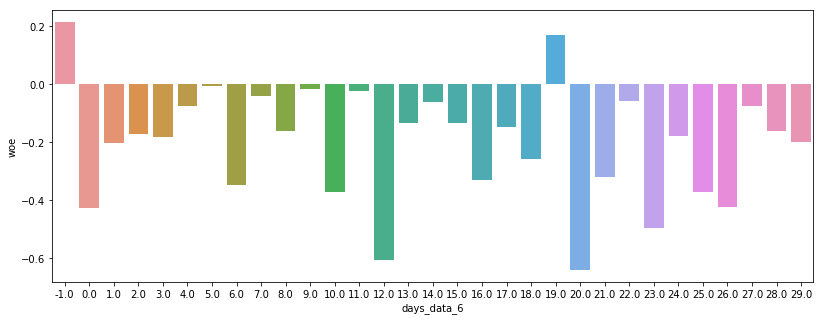

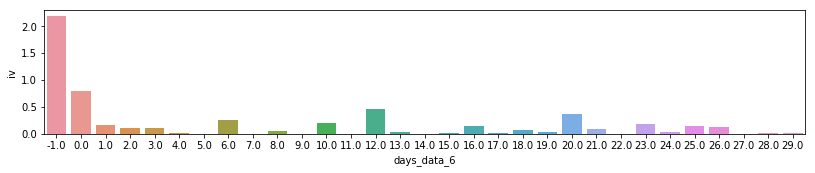

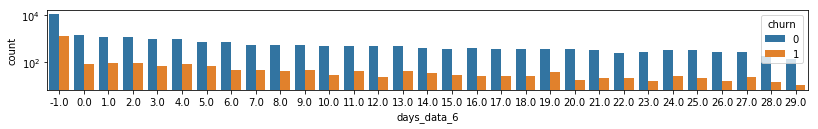

In [52]:
diffdate('date_of_last_rech_data_6','days_data_6',2014,6,30)
f = iv('days_data_6')

In [53]:
diffdate('date_of_last_rech_data_7','days_data_7',2014,7,31)

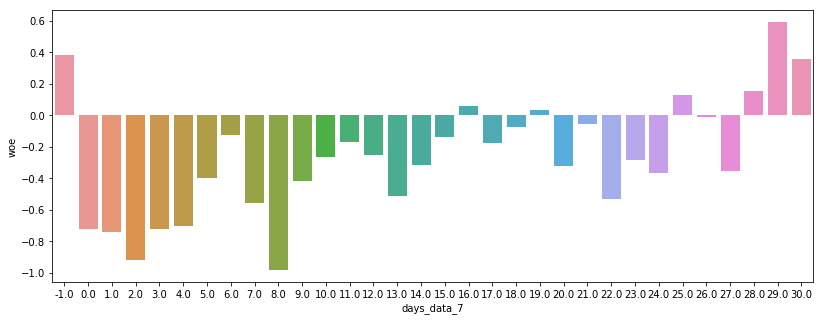

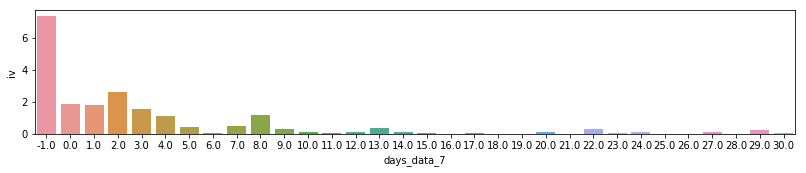

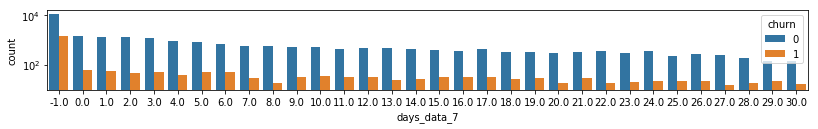

In [54]:
f = iv('days_data_7')

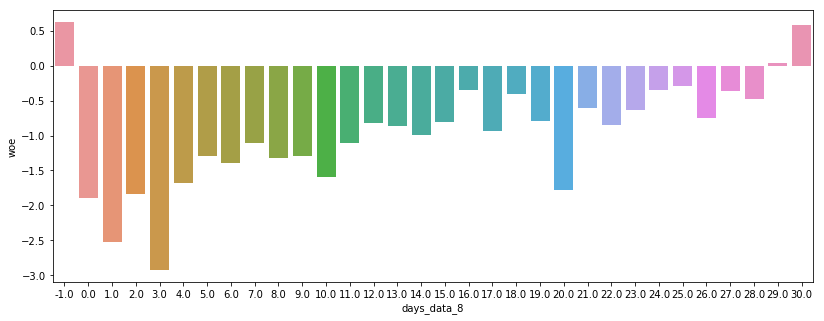

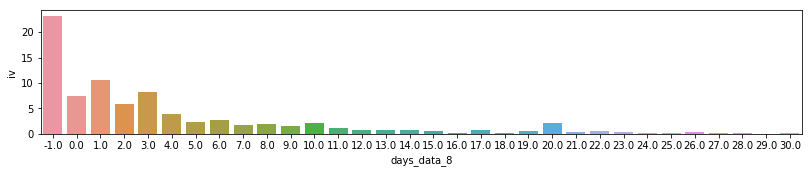

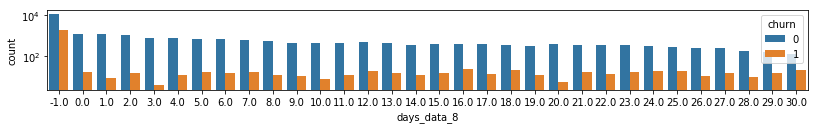

In [55]:
diffdate('date_of_last_rech_data_8','days_data_8',2014,8,31)
f = iv('days_data_8')

In [56]:
###For the days last Recharge 6 & 7 a clear pattern of woe is not there
###Using days Last Recharge For 8 as it intuitively makes senese too 
###--Anyone recharging very late (last week ) will Likely stick to the Model

telecom_df_base['data_bad_last'] = "No_Recharge"
telecom_df_base.loc[telecom_df_base.days_data_8 > -1,'data_bad_last'] = "Last_Week_Recharge"
telecom_df_base.loc[telecom_df_base.days_data_8 > 6,'data_bad_last'] = "Other_Days"

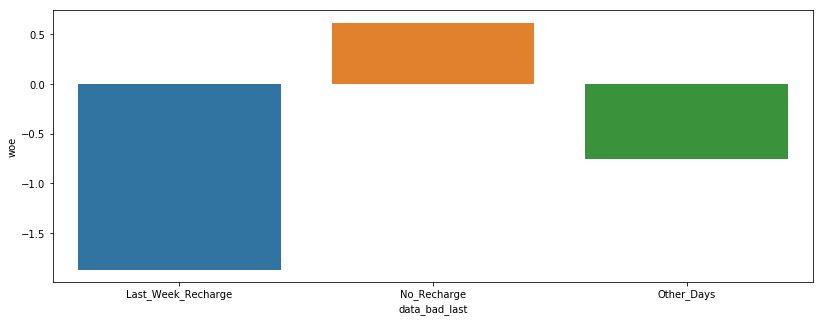

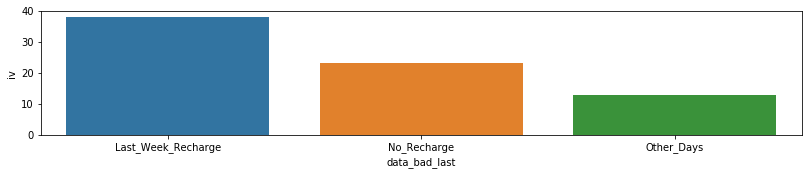

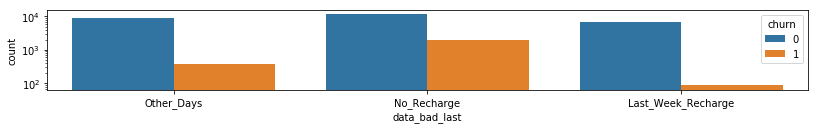

In [57]:
f = iv('data_bad_last')

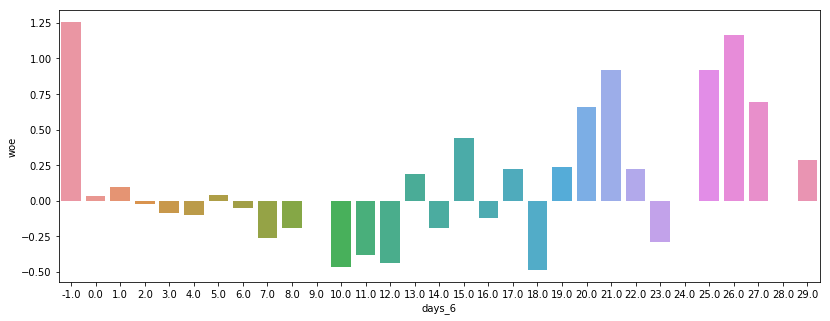

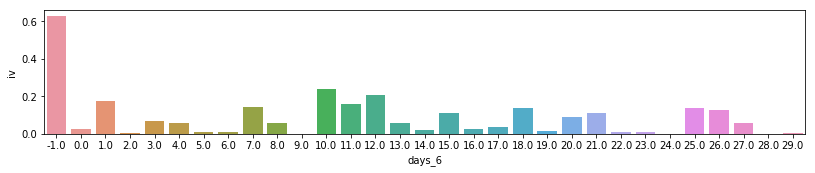

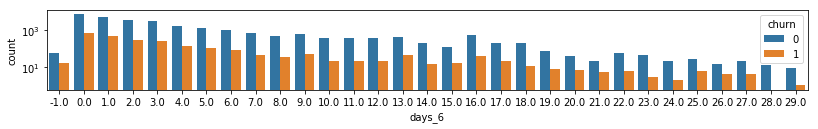

In [58]:
diffdate('date_of_last_rech_6','days_6',2014,6,30)
f = iv('days_6')

In [59]:
telecom_df_base['days_6_flag'] = "Otherdays"
telecom_df_base.loc[telecom_df_base.days_6 < 2,'days_6_flag'] = "Last two days"
telecom_df_base.loc[telecom_df_base.days_6 < 0,'days_6_flag'] = "Missing"

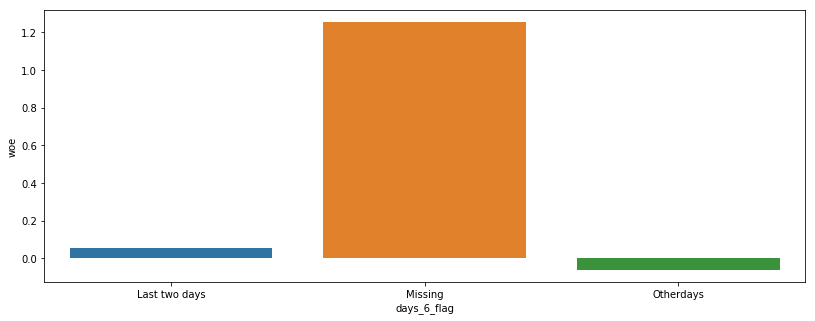

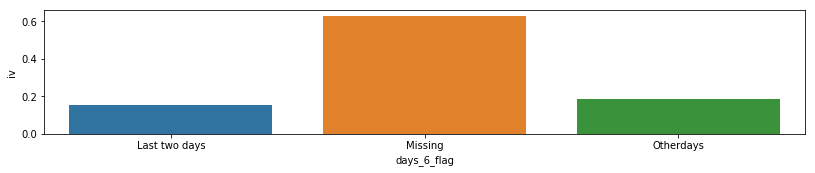

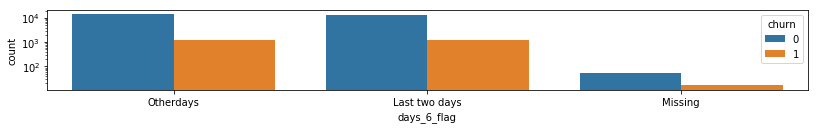

In [60]:
f = iv('days_6_flag')

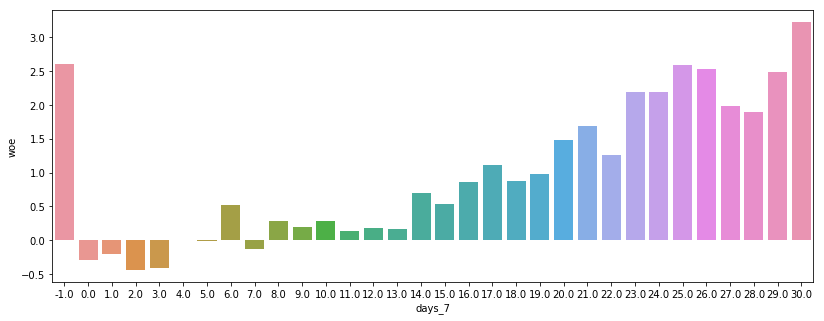

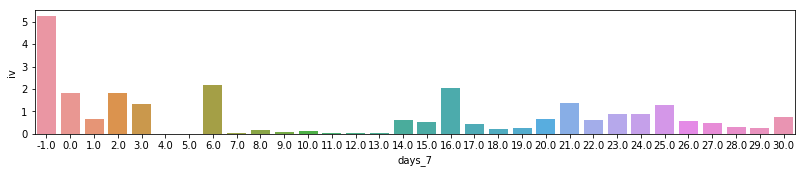

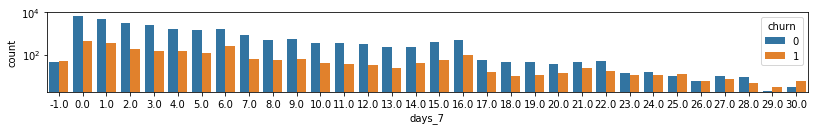

In [61]:
diffdate('date_of_last_rech_7','days_7',2014,7,31)
f = iv('days_7')

In [62]:
telecom_df_base['days_7_flag'] = "Otherdays"
telecom_df_base.loc[telecom_df_base.days_7 < 6,'days_7_flag'] = "Last Six days"
telecom_df_base.loc[telecom_df_base.days_7 < 0,'days_7_flag'] = "Missing"

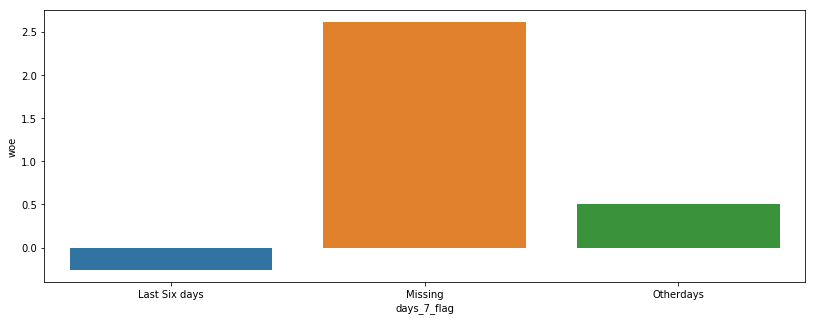

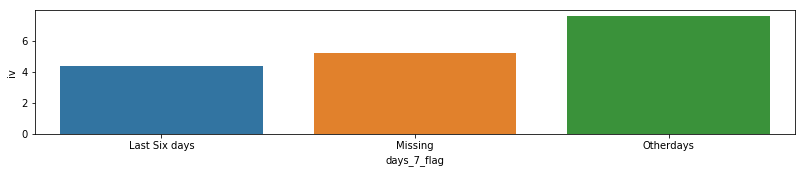

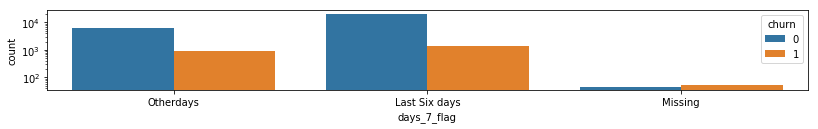

In [63]:
f = iv('days_7_flag')

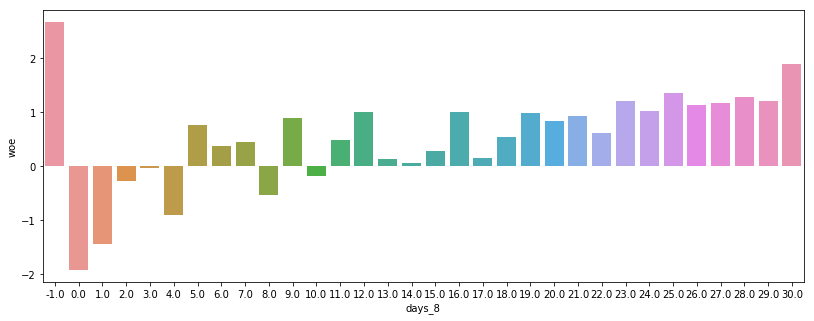

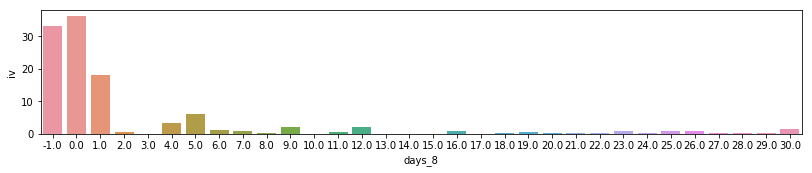

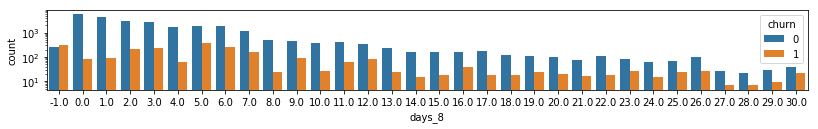

In [64]:
diffdate('date_of_last_rech_8','days_8',2014,8,31)
f = iv('days_8')

In [65]:
telecom_df_base['days_8_flag'] = "Otherdays"
telecom_df_base.loc[telecom_df_base.days_8 < 2,'days_8_flag'] = "Last two days"
telecom_df_base.loc[telecom_df_base.days_8 < 0,'days_8_flag'] = "Missing"

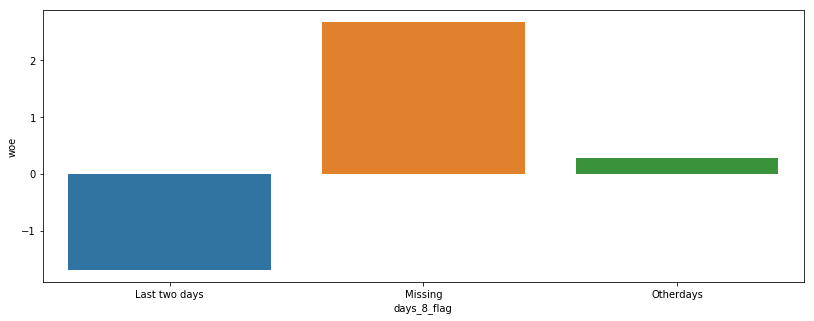

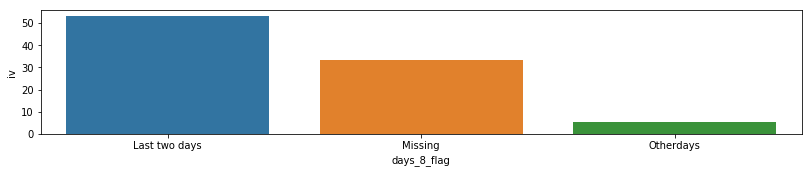

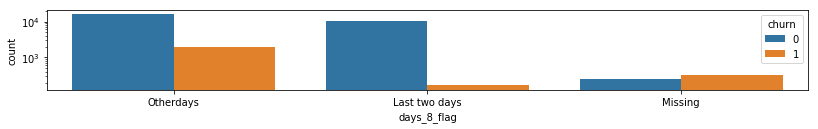

In [66]:
f = iv('days_8_flag')

In [67]:
###dropping all Dates related columns
cols = ['date_of_last_rech_data_6','days_data_6','date_of_last_rech_data_7','days_data_7',
       'date_of_last_rech_data_8','days_data_8','date_of_last_rech_6','days_6',
       'date_of_last_rech_7','days_7','date_of_last_rech_8','days_8']
telecom_df_base.drop(cols , axis = 1, inplace = True)
telecom_df_base.shape

(30001, 157)

# Date Part Ends 

# Categorical Data Replacement with WOE

In [68]:
###Tackling all Potential Categorical Data 
cols = list(telecom_df_base.loc[:,telecom_df_base.apply(lambda x: len(x.unique())) <= 20].columns)
cols.remove('churn')
telecom_df_base[cols].apply(lambda x: len(x.unique()))

night_pck_user_6     3
night_pck_user_7     3
night_pck_user_8     3
monthly_2g_6         5
monthly_2g_7         6
monthly_2g_8         6
monthly_3g_6        12
monthly_3g_7        15
monthly_3g_8        12
fb_user_6            3
fb_user_7            3
fb_user_8            3
data_bad_last        3
days_6_flag          3
days_7_flag          3
days_8_flag          3
dtype: int64

In [69]:
def woe_imp(x):
    
    churns = sum(telecom_df_base.churn == 1)
    nonchurns = sum(telecom_df_base.churn == 0)
    event = telecom_df_base.groupby(x).churn.apply(lambda x: round(sum(x == 1)/churns*100,2))
    nonevent = telecom_df_base.groupby(x).churn.apply(lambda x: round(sum(x == 0)/nonchurns*100,2))
    count = telecom_df_base.groupby(x).churn.count()
    tab = pd.concat([event , nonevent , count] , axis = 1)
    tab.reset_index(inplace = True)
    tab.columns = [x,"event","nonevent","count"]
    rows = ~((tab.event == 0) | (tab.nonevent == 0))
    tab['woe'] = 0
    tab.loc[rows,'woe'] = (tab.loc[rows,'event']/tab.loc[rows,'nonevent']).map(lambda x: math.log(x))
    tab = tab[[x,'woe']]
    a = x+'_'+'woe'
    tab.columns = [x ,a ]
    tab = pd.merge(telecom_df_base , tab , how = "inner" , on = x)
    tab.drop(x,axis =1 , inplace = True)
    return(tab)

In [70]:
###The ones with 3 are non ordinal so I can simple replace the Categoricals with WOE
cols = list(telecom_df_base.loc[:,telecom_df_base.apply(lambda x: len(x.unique())) == 3].columns)
for col in cols:
    telecom_df_base = woe_imp(col)
telecom_df_base.shape
    

(30001, 157)

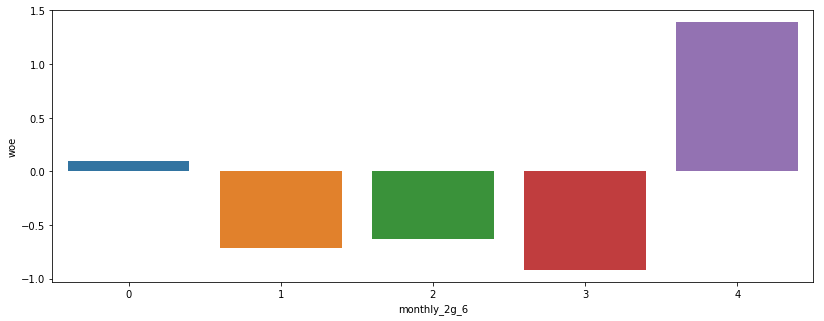

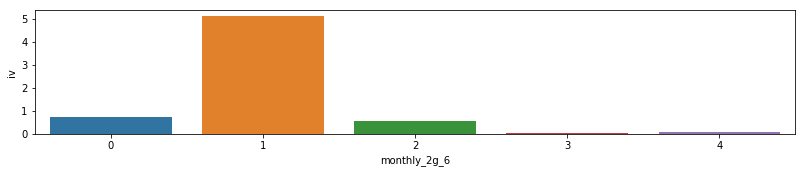

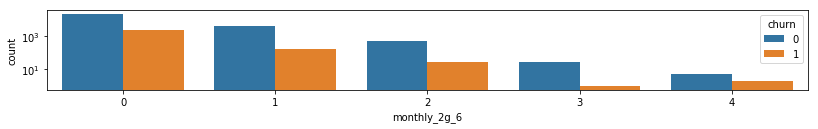

,monthly_2g_6,event,nonevent,count,woe,iv
0,0,92.01,83.99,25394,0.091200,0.731420
1,1,6.84,13.98,4021,-0.714840,5.103958
2,2,1.02,1.91,551,-0.627301,0.558298
3,3,0.04,0.10,28,-0.916291,0.054977
4,4,0.08,0.02,7,1.386294,0.083178


In [71]:
###For ordinal variables I will have to plot the woe before imputations
f = iv('monthly_2g_6')
f

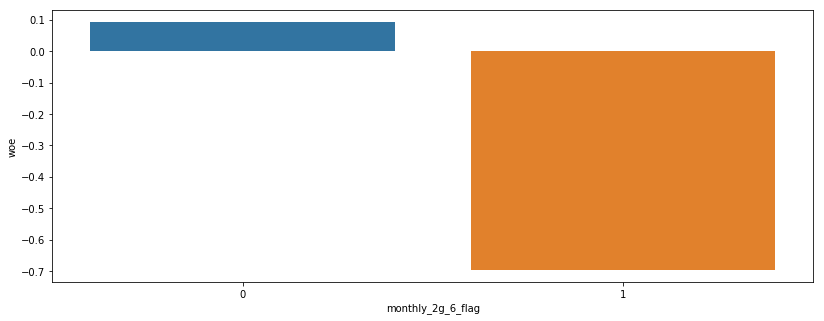

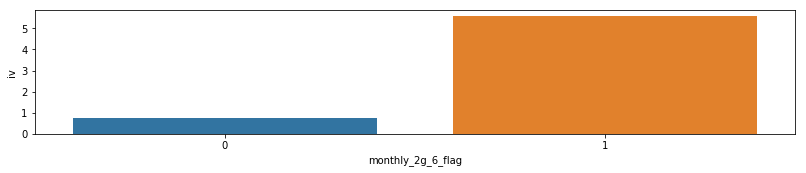

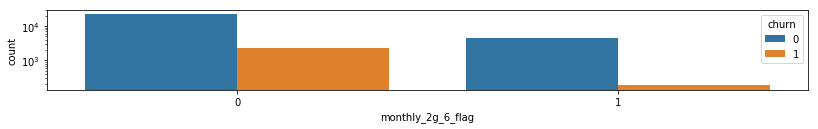

,monthly_2g_6_flag,event,nonevent,count,woe,iv
0,0,92.01,83.99,25394,0.091200,0.731420
1,1,7.99,16.01,4607,-0.695023,5.574083


In [72]:
###As can be seen the break will make sense if I switch it to a 0-1 Model:
telecom_df_base['monthly_2g_6_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_2g_6 > 0,'monthly_2g_6_flag'] = 1
f = iv('monthly_2g_6_flag')
f

In [73]:
####Replacing the Flag with WOE Values and dropping the Original columns 
telecom_df_base.drop(['monthly_2g_6'] , axis = 1 , inplace = True)
telecom_df_base = woe_imp('monthly_2g_6_flag')

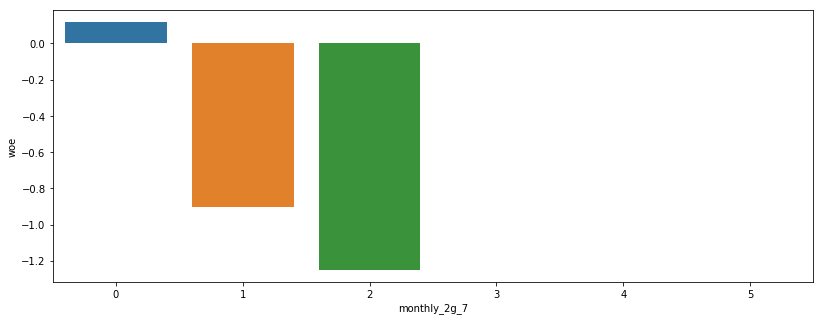

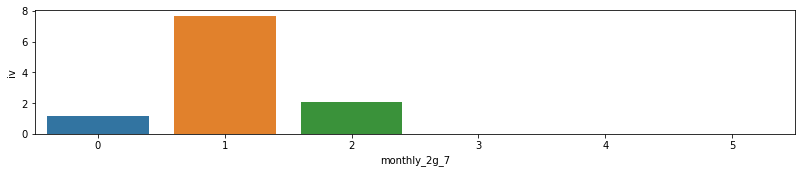

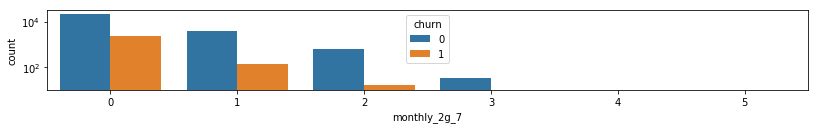

,monthly_2g_7,event,nonevent,count,woe,iv
0,0,93.57,83.30,25241,0.116261,1.194003
1,1,5.78,14.26,4071,-0.903055,7.657904
2,2,0.66,2.30,649,-1.248425,2.047416
3,3,0.00,0.12,33,0.000000,-0.000000
4,4,0.00,0.02,5,0.000000,-0.000000
5,5,0.00,0.01,2,0.000000,-0.000000


In [74]:
###For ordinal variables I will have to plot the woe before imputations
f = iv('monthly_2g_7')
f

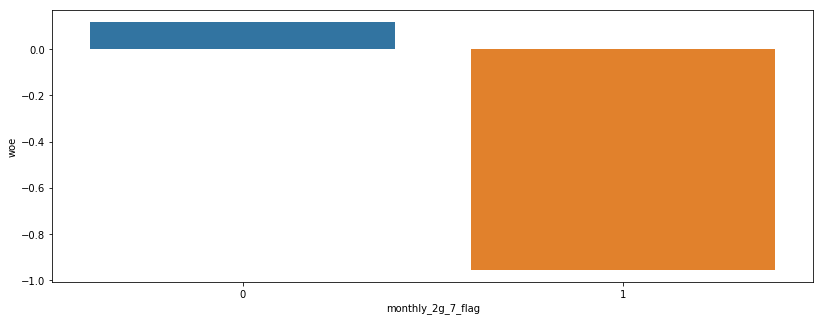

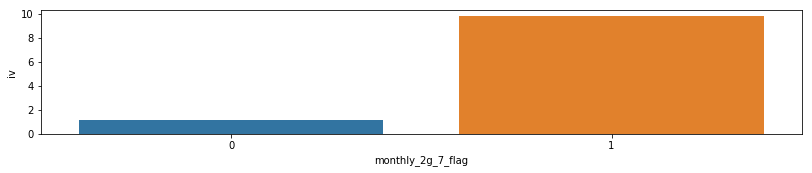

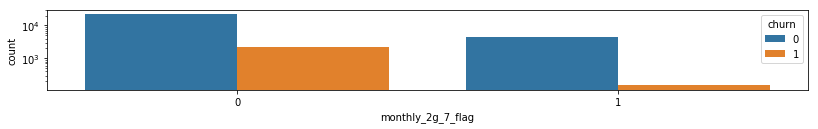

,monthly_2g_7_flag,event,nonevent,count,woe,iv
0,0,93.57,83.3,25241,0.116261,1.194003
1,1,6.43,16.7,4760,-0.954434,9.802039


In [75]:
###Makes sense to transform into a 0-1 Variable to align with 6 
telecom_df_base['monthly_2g_7_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_2g_7 > 0,'monthly_2g_7_flag'] = 1
f = iv('monthly_2g_7_flag')
f

In [76]:
####Replacing the Flag with WOE Values and dropping the Original columns 
telecom_df_base.drop(['monthly_2g_7'] , axis = 1 , inplace = True)
telecom_df_base = woe_imp('monthly_2g_7_flag')

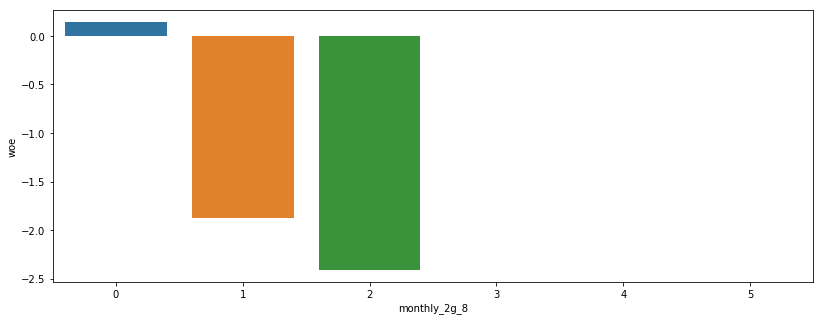

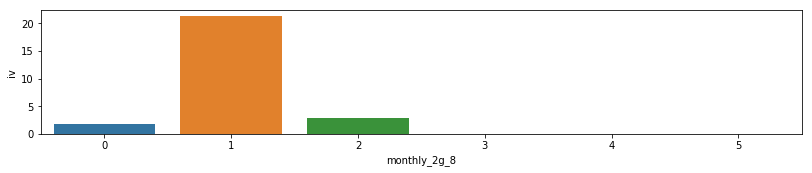

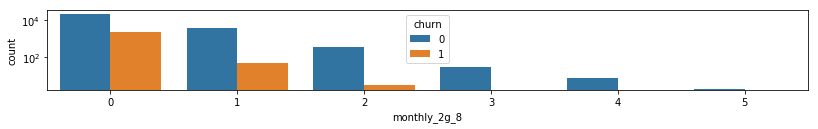

,monthly_2g_8,event,nonevent,count,woe,iv
0,0,97.83,85.15,25854,0.138817,1.760198
1,1,2.05,13.38,3737,-1.875921,21.254188
2,2,0.12,1.33,370,-2.405442,2.910585
3,3,0.00,0.11,30,0.000000,-0.000000
4,4,0.00,0.03,8,0.000000,-0.000000
5,5,0.00,0.01,2,0.000000,-0.000000


In [77]:
###For ordinal variables I will have to plot the woe before imputations
f = iv('monthly_2g_8')
f

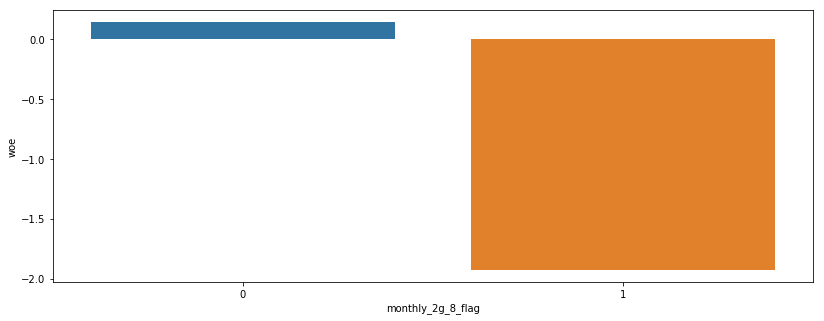

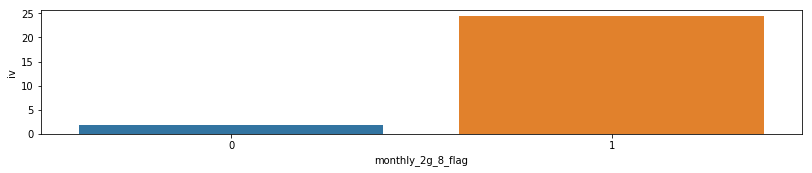

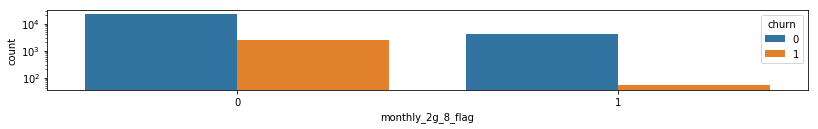

,monthly_2g_8_flag,event,nonevent,count,woe,iv
0,0,97.83,85.15,25854,0.138817,1.760198
1,1,2.17,14.85,4147,-1.923273,24.387098


In [78]:
###Makes sense to transform into a 0-1 Variable to align with 6 and 7
telecom_df_base['monthly_2g_8_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_2g_8 > 0,'monthly_2g_8_flag'] = 1
f = iv('monthly_2g_8_flag')
f

In [79]:
####Replacing the Flag with WOE Values and dropping the Original columns 
telecom_df_base.drop(['monthly_2g_8'] , axis = 1 , inplace = True)
telecom_df_base = woe_imp('monthly_2g_8_flag')

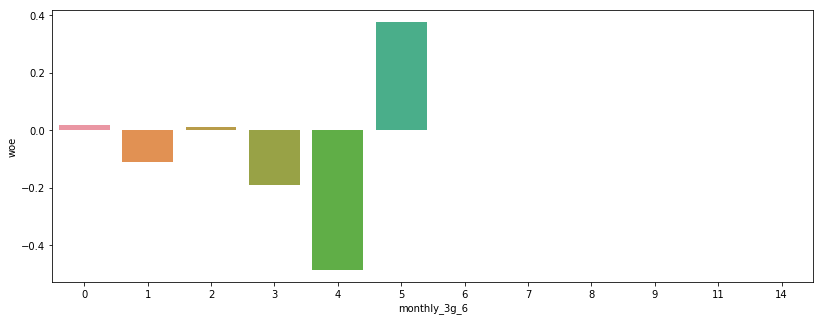

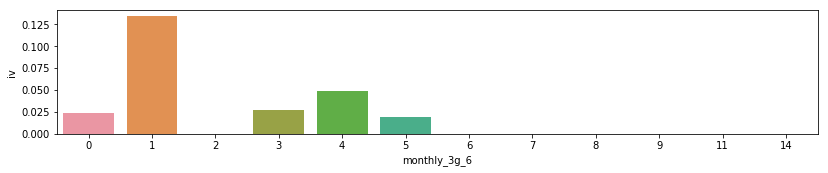

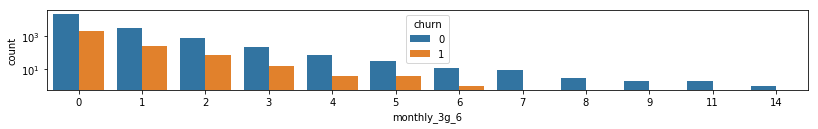

,monthly_3g_6,event,nonevent,count,woe,iv
0,0,85.78,84.35,25342,0.016811,0.024040
1,1,10.32,11.53,3431,-0.110869,0.134151
2,2,2.87,2.84,852,0.010508,0.000315
3,3,0.66,0.80,237,-0.192372,0.026932
4,4,0.16,0.26,76,-0.485508,0.048551
5,5,0.16,0.11,34,0.374693,0.018735
6,6,0.04,0.04,12,0.000000,0.000000
7,7,0.00,0.03,9,0.000000,-0.000000
8,8,0.00,0.01,3,0.000000,-0.000000
9,9,0.00,0.01,2,0.000000,-0.000000


In [80]:
###For ordinal variables I will have to plot the woe before imputations
f = iv('monthly_3g_6')
f

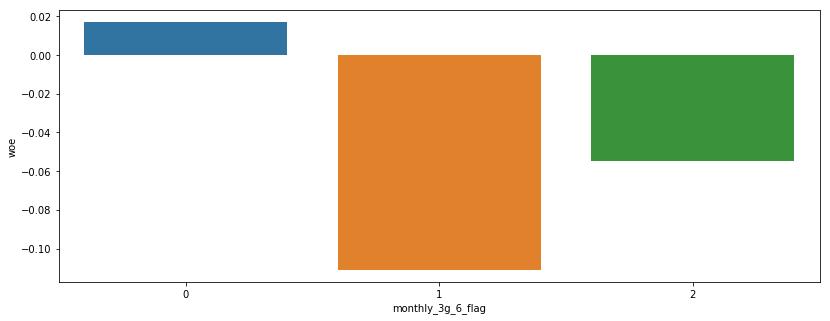

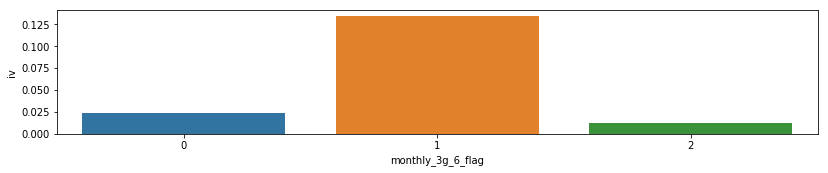

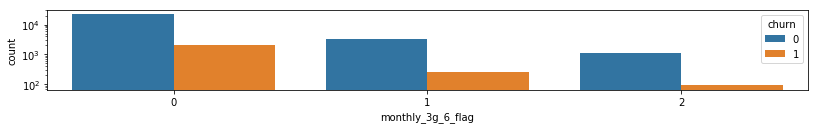

,monthly_3g_6_flag,event,nonevent,count,woe,iv
0,0,85.78,84.35,25342,0.016811,0.024040
1,1,10.32,11.53,3431,-0.110869,0.134151
2,2,3.89,4.11,1228,-0.055014,0.012103


In [81]:
###Makes sense to transform into a 0-1 Variable to align with 6 and 7
telecom_df_base['monthly_3g_6_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_3g_6 > 0,'monthly_3g_6_flag'] = 1
telecom_df_base.loc[telecom_df_base.monthly_3g_6 > 1,'monthly_3g_6_flag'] = 2
f = iv('monthly_3g_6_flag')
f

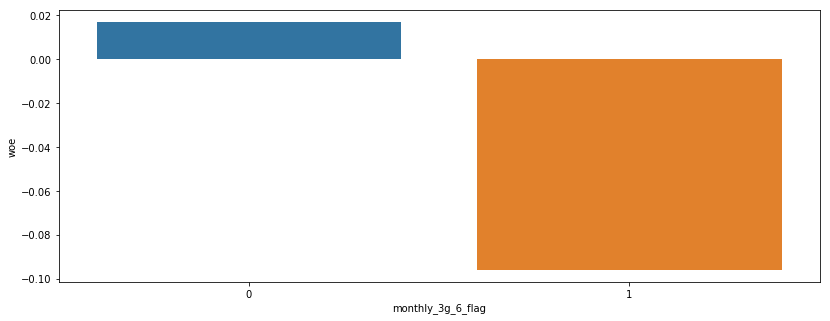

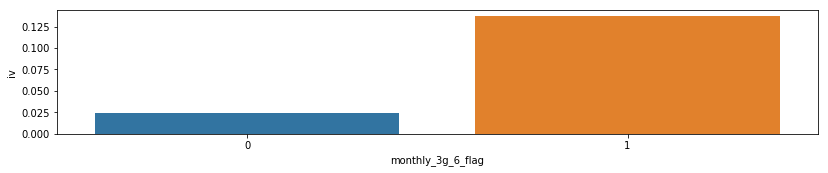

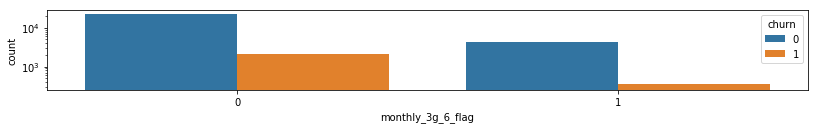

,monthly_3g_6_flag,event,nonevent,count,woe,iv
0,0,85.78,84.35,25342,0.016811,0.024040
1,1,14.22,15.65,4659,-0.095821,0.137025


In [82]:
##WOE is not working so taking it to two Variables 
telecom_df_base['monthly_3g_6_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_3g_6 > 0,'monthly_3g_6_flag'] = 1
f = iv('monthly_3g_6_flag')
f

In [83]:
####Replacing the Flag with WOE Values and dropping the Original columns 
telecom_df_base.drop(['monthly_3g_6'] , axis = 1 , inplace = True)
telecom_df_base = woe_imp('monthly_3g_6_flag')

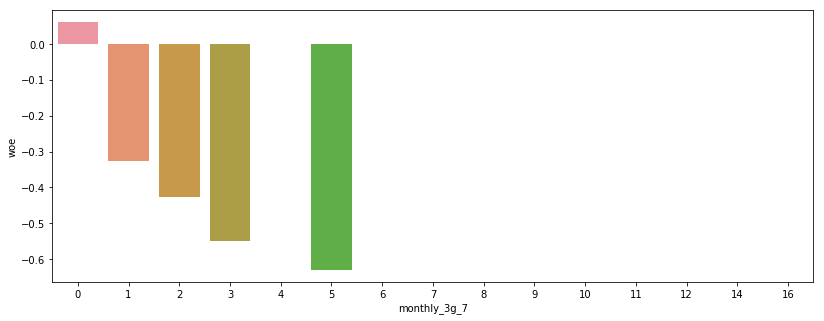

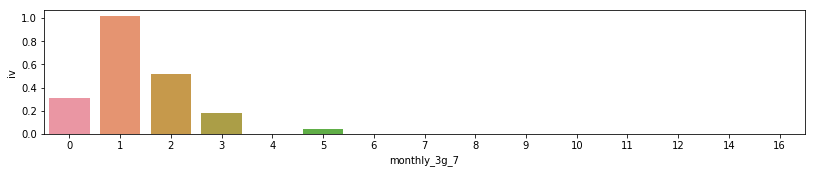

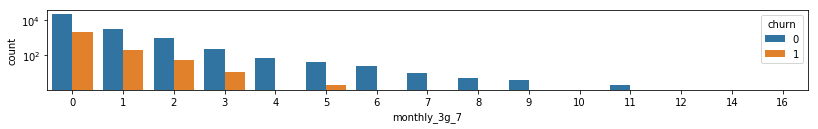

,monthly_3g_7,event,nonevent,count,woe,iv
0,0,89.10,83.93,25306,0.059776,0.309043
1,1,8.11,11.23,3294,-0.325491,1.015532
2,2,2.25,3.45,1007,-0.427444,0.512933
3,3,0.45,0.78,227,-0.550046,0.181515
4,4,0.00,0.27,74,0.000000,-0.000000
5,5,0.08,0.15,42,-0.628609,0.044003
6,6,0.00,0.09,26,0.000000,-0.000000
7,7,0.00,0.04,10,0.000000,-0.000000
8,8,0.00,0.02,5,0.000000,-0.000000
9,9,0.00,0.01,4,0.000000,-0.000000


In [84]:
###For ordinal variables I will have to plot the woe before imputations
f = iv('monthly_3g_7')
f

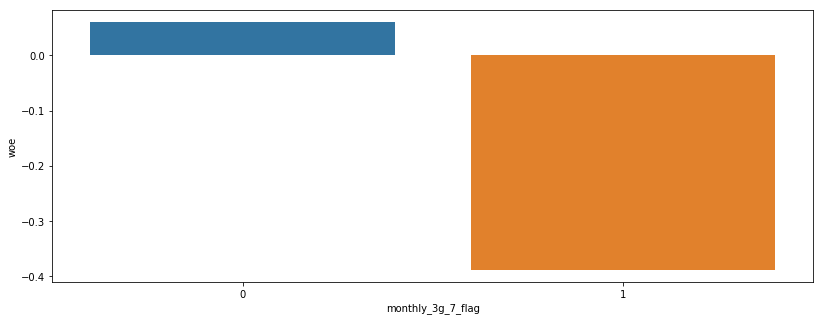

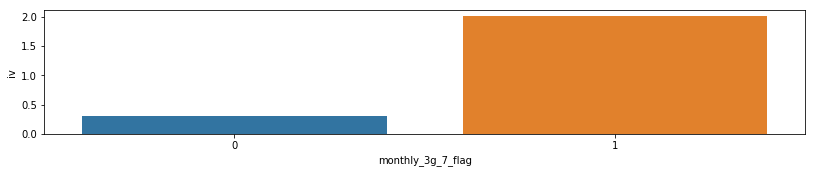

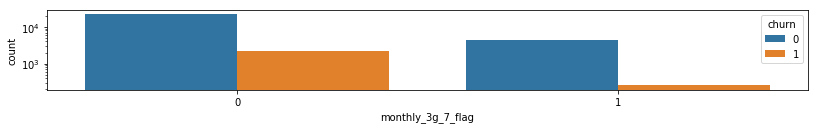

,monthly_3g_7_flag,event,nonevent,count,woe,iv
0,0,89.1,83.93,25306,0.059776,0.309043
1,1,10.9,16.07,4695,-0.388191,2.006949


In [85]:
##It follows a wider pattern but will align it with 3g_6
telecom_df_base['monthly_3g_7_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_3g_7 > 0,'monthly_3g_7_flag'] = 1
f = iv('monthly_3g_7_flag')
f

In [86]:
####Replacing the Flag with WOE Values and dropping the Original columns 
telecom_df_base.drop(['monthly_3g_7'] , axis = 1 , inplace = True)
telecom_df_base = woe_imp('monthly_3g_7_flag')

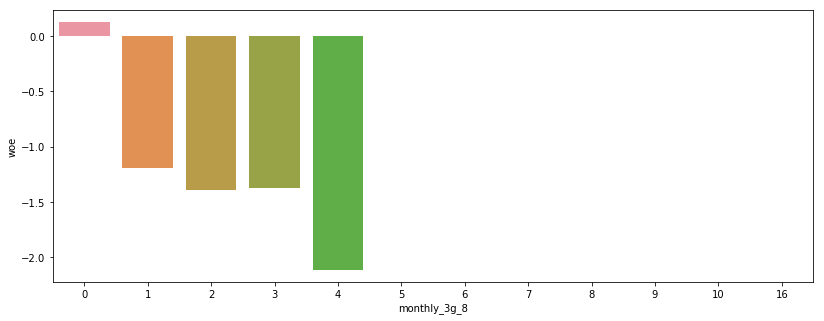

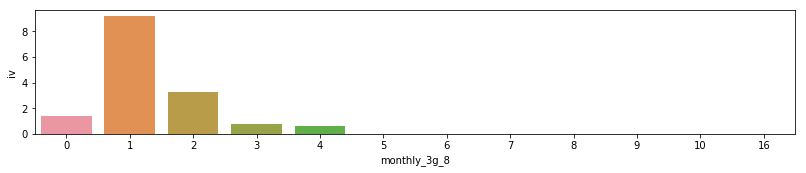

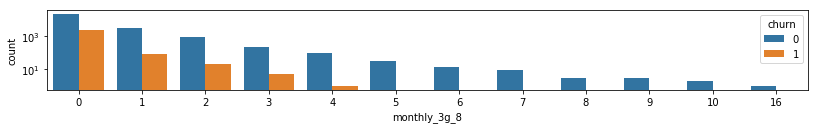

,monthly_3g_8,event,nonevent,count,woe,iv
0,0,95.62,84.44,25605,0.124341,1.390130
1,1,3.36,11.07,3133,-1.192298,9.192616
2,2,0.78,3.14,884,-1.392684,3.286735
3,3,0.20,0.79,224,-1.373716,0.810492
4,4,0.04,0.33,91,-2.110213,0.611962
5,5,0.00,0.12,32,0.000000,-0.000000
6,6,0.00,0.05,14,0.000000,-0.000000
7,7,0.00,0.03,9,0.000000,-0.000000
8,8,0.00,0.01,3,0.000000,-0.000000
9,9,0.00,0.01,3,0.000000,-0.000000


In [87]:
###For ordinal variables I will have to plot the woe before imputations
f = iv('monthly_3g_8')
f

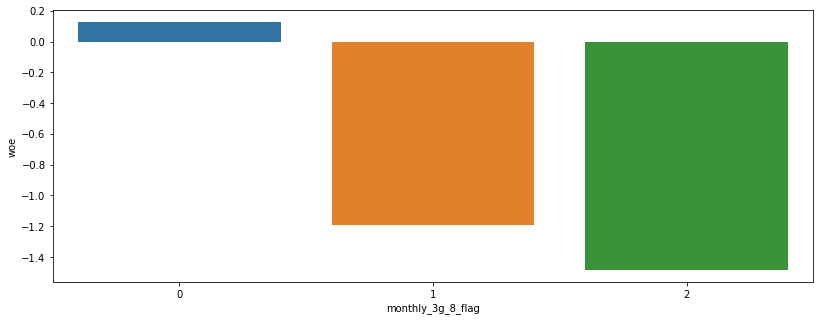

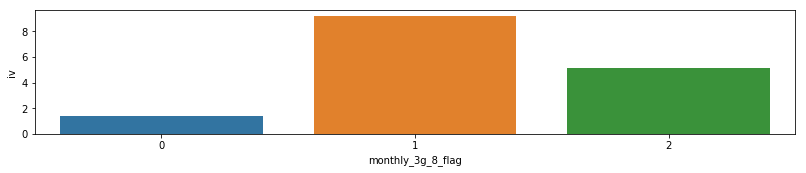

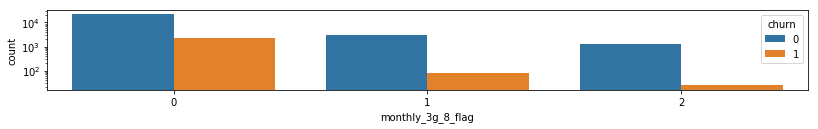

,monthly_3g_8_flag,event,nonevent,count,woe,iv
0,0,95.62,84.44,25605,0.124341,1.390130
1,1,3.36,11.07,3133,-1.192298,9.192616
2,2,1.02,4.49,1263,-1.482050,5.142714


In [88]:
##Based on the starc diff in woe going for three cuts
telecom_df_base['monthly_3g_8_flag'] = 0 
telecom_df_base.loc[telecom_df_base.monthly_3g_8 > 0,'monthly_3g_8_flag'] = 1
telecom_df_base.loc[telecom_df_base.monthly_3g_8 > 1,'monthly_3g_8_flag'] = 2
f = iv('monthly_3g_8_flag')
f

In [89]:
####Replacing the Flag with WOE Values and dropping the Original columns 
telecom_df_base.drop(['monthly_3g_8'] , axis = 1 , inplace = True)
telecom_df_base = woe_imp('monthly_3g_8_flag')

# Categorical_WOE part Ends

# Tackling The element of Time in the datasets

In [90]:
####Constructing and Deconstructing Variables on the basis of Phase 
a6 = [cols for cols in telecom_df_base.columns if cols.endswith('6')]
a6.sort()
a7 = [cols for cols in telecom_df_base.columns if cols.endswith('7')]
a7.sort()
a8 = [cols for cols in telecom_df_base.columns if cols.endswith('8')]
a8.sort()

In [91]:
coeff_67 = list()
coeff_67 = [np.corrcoef(telecom_df_base[x] ,telecom_df_base[y])[0,1] for x , y in zip(a6,a7)]

In [92]:
corrs = pd.DataFrame([a6,a7,coeff_67]).T
corrs.columns = ['m6','m7','corr']
corrs.sort_values('corr' , ascending = False)

,m6,m7,corr
8,isd_og_mou_6,isd_og_mou_7,0.915247
10,loc_ic_mou_6,loc_ic_mou_7,0.821027
16,loc_og_t2f_mou_6,loc_og_t2f_mou_7,0.809061
14,loc_og_mou_6,loc_og_mou_7,0.806892
38,total_ic_mou_6,total_ic_mou_7,0.803042
13,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,0.801786
18,loc_og_t2t_mou_6,loc_og_t2t_mou_7,0.7944
12,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,0.791456
17,loc_og_t2m_mou_6,loc_og_t2m_mou_7,0.784296
23,onnet_mou_6,onnet_mou_7,0.750708


In [93]:
###Almost all Variables show an extremely strong correlation between month 6 and 7
###This makes sense too as the habits tend to carry on till the next month too
##3Hence Creating delta Variables instead of originals
for x , y in zip(a6,a7):
    z = x.replace('6','delta1')
    telecom_df_base[z] = telecom_df_base[y] - telecom_df_base[x]
a9 = [cols for cols in telecom_df_base.columns if cols.endswith('delta1')]
a9.sort()
coeff = list()
coeff = [np.corrcoef(telecom_df_base[x] ,telecom_df_base[y])[0,1] for x , y in zip(a6,a9)]
corrs = pd.DataFrame([a6,a9,coeff]).T
corrs.columns = ['m6','delta1','corr']
corrs.sort_values('corr' , ascending = False)

,m6,delta1,corr
8,isd_og_mou_6,isd_og_mou_delta1,-0.221451
18,loc_og_t2t_mou_6,loc_og_t2t_mou_delta1,-0.249992
6,ic_others_6,ic_others_delta1,-0.26018
30,std_ic_mou_6,std_ic_mou_delta1,-0.266816
11,loc_ic_t2f_mou_6,loc_ic_t2f_mou_delta1,-0.266966
33,std_ic_t2t_mou_6,std_ic_t2t_mou_delta1,-0.275712
38,total_ic_mou_6,total_ic_mou_delta1,-0.281697
36,std_og_t2m_mou_6,std_og_t2m_mou_delta1,-0.282455
13,loc_ic_t2t_mou_6,loc_ic_t2t_mou_delta1,-0.282983
35,std_og_t2f_mou_6,std_og_t2f_mou_delta1,-0.292399


In [94]:
##for 7 & 8 
coeff = list()
coeff = [np.corrcoef(telecom_df_base[x] ,telecom_df_base[y])[0,1] for x , y in zip(a7,a8)]
corrs = pd.DataFrame([a7,a8,coeff]).T
corrs.columns = ['m7','m8','corr']
corrs.sort_values('corr' , ascending = False)

,m7,m8,corr
8,isd_og_mou_7,isd_og_mou_8,0.94312
14,loc_og_mou_7,loc_og_mou_8,0.841927
10,loc_ic_mou_7,loc_ic_mou_8,0.840179
18,loc_og_t2t_mou_7,loc_og_t2t_mou_8,0.833081
17,loc_og_t2m_mou_7,loc_og_t2m_mou_8,0.823666
38,total_ic_mou_7,total_ic_mou_8,0.820529
12,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,0.812493
13,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,0.806793
23,onnet_mou_7,onnet_mou_8,0.806053
37,std_og_t2t_mou_7,std_og_t2t_mou_8,0.802101


In [95]:
##Again we see Strong correlations between the two 
##So dropping the 8 and inserting delta two variables 
for x , y in zip(a7,a8):
    z = x.replace('7','delta2')
    telecom_df_base[z] = telecom_df_base[y] - telecom_df_base[x]
a10 = [cols for cols in telecom_df_base.columns if cols.endswith('delta2')]
a10.sort()
coeff = list()
coeff = [np.corrcoef(telecom_df_base[x] ,telecom_df_base[y])[0,1] for x , y in zip(a7,a10)]
corrs = pd.DataFrame([a7,a10,coeff]).T
corrs.columns = ['m7','delta2','corr']
corrs.sort_values('corr' , ascending = False)

,m7,delta2,corr
8,isd_og_mou_7,isd_og_mou_delta2,-0.221502
22,og_others_7,og_others_delta2,-0.260586
2,arpu_7,arpu_delta2,-0.288589
40,total_rech_amt_7,total_rech_amt_delta2,-0.32119
10,loc_ic_mou_7,loc_ic_mou_delta2,-0.322443
12,loc_ic_t2m_mou_7,loc_ic_t2m_mou_delta2,-0.329061
14,loc_og_mou_7,loc_og_mou_delta2,-0.334043
17,loc_og_t2m_mou_7,loc_og_t2m_mou_delta2,-0.347581
38,total_ic_mou_7,total_ic_mou_delta2,-0.35102
31,std_ic_t2f_mou_7,std_ic_t2f_mou_delta2,-0.354454


In [96]:
###Dropping variables 7 & 8 from the list 
a78 = a7
a78.extend(a8)
telecom_df_base = telecom_df_base.drop(a78 , axis = 1)
telecom_df_base.shape

(30001, 157)

In [97]:
telecom_df_base.drop(['mobile_number'] , axis = 1 , inplace = True)
telecom_df_base.shape

(30001, 156)

In [98]:
X = telecom_df_base.drop('churn',axis=1)
y = telecom_df_base.loc[:,'churn']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

In [100]:
pca = PCA()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
X_train_pca = pca.fit_transform(X_train)
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_pca,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [102]:
X_test_pca = pca.transform(X_test)
y_pred = lr.predict(X_test_pca)

metrics.recall_score(y_test,y_pred)

0.8079561042524005

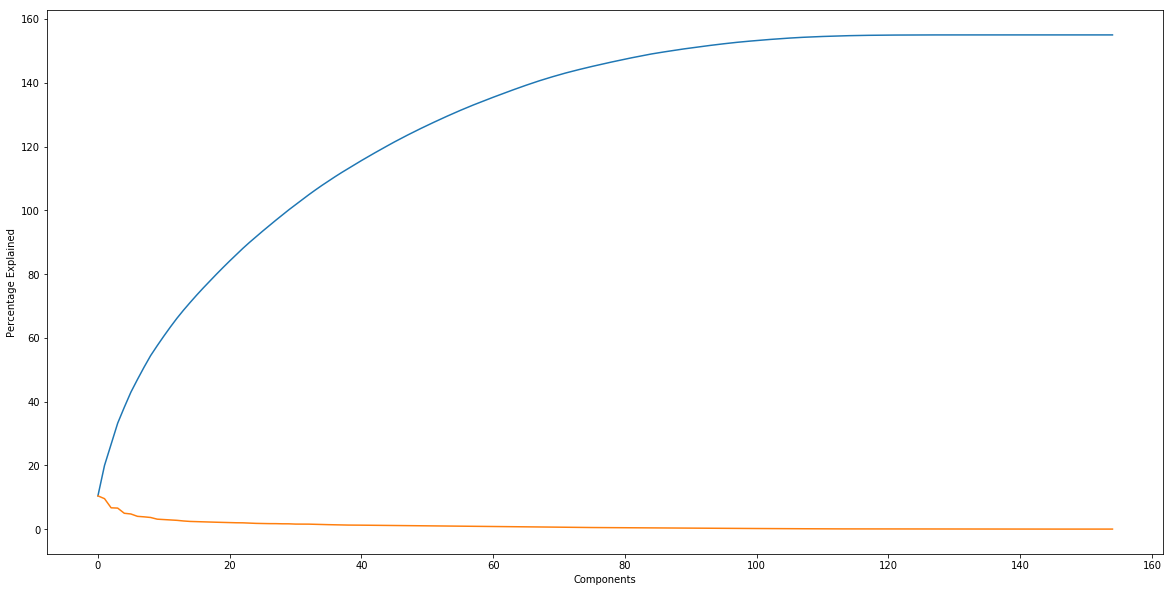

In [103]:
plt.figure(figsize=(20,10))
plt.xlabel('Components')
plt.ylabel('Percentage Explained')
plt.plot(np.cumsum(pca.explained_variance_))
plt.plot(pca.explained_variance_)
plt.show()

In [104]:
pca_30 = PCA(30)
X_train_pca = pca_30.fit_transform(X_train)
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_pca,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [126]:
X_test_pca = pca_30.transform(X_test)
y_pred = lr.predict(X_test_pca)

0.7914951989026063
0.8220197755804911


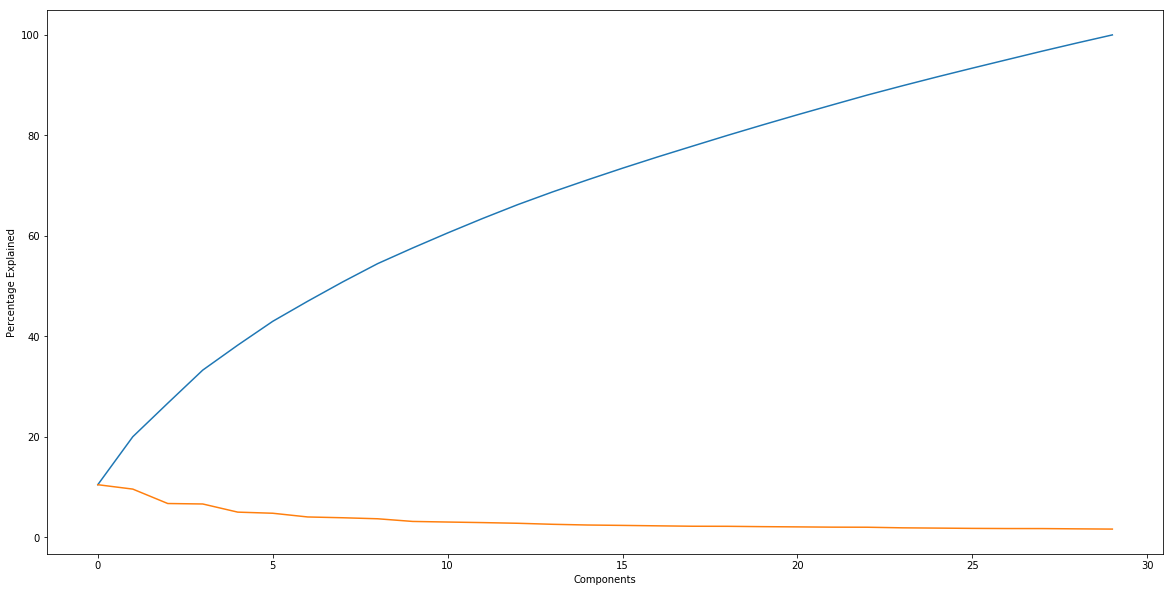

In [106]:
plt.figure(figsize=(20,10))
plt.xlabel('Components')
plt.ylabel('Percentage Explained')
plt.plot(np.cumsum(pca_30.explained_variance_))
plt.plot(pca_30.explained_variance_)
plt.show()

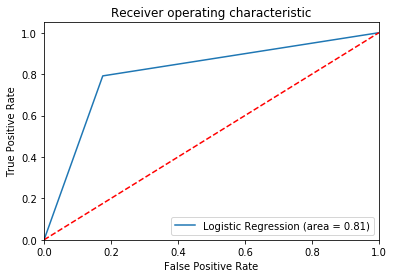

0.7914951989026063
0.8220197755804911
[[6822 1450]
 [ 152  577]]


In [107]:
# ROC curve - Logistic Regression
logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

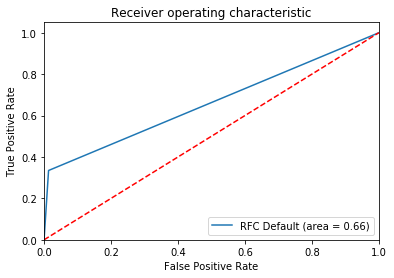

0.3347050754458162
0.9337851349850017
[[8161  111]
 [ 485  244]]


In [108]:
rfc_default_params = RandomForestClassifier(class_weight='balanced',n_jobs=10)

rfc_default_params.fit(X_train,y_train)
y_pred = rfc_default_params.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='RFC Default (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

In [109]:
rfc = RandomForestClassifier(class_weight='balanced',n_jobs=10)

params = [{'n_estimators' : range(10,100,5)},
          {'max_depth':range(3,50,1)},
          {'min_samples_split' : range(10,100,2)},
          {'max_features':['auto','sqrt','log2']}]

rfc_gs = GridSearchCV(rfc,params,cv=5,scoring='recall',return_train_score=True)
rfc_gs.fit(X_train,y_train)
print(rfc_gs.best_score_)
print(rfc_gs.best_params_)

0.8060577813175633
{'max_depth': 3}


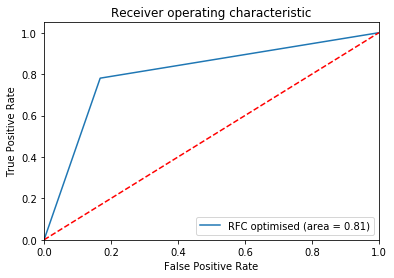

0.7805212620027435
0.8282413065214976
[[6886 1386]
 [ 160  569]]


In [110]:
rfc_final = RandomForestClassifier(class_weight='balanced',max_depth=3)
rfc_final.fit(X_train,y_train)
y_pred = rfc_final.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='RFC optimised (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

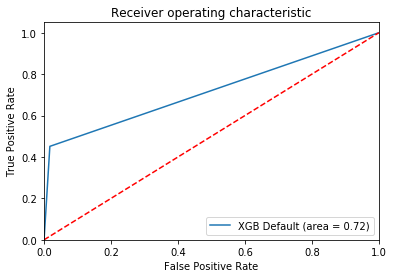

0.4513031550068587
0.9396733696255971
[[8129  143]
 [ 400  329]]


In [111]:
xgb_default_params = XGBClassifier(class_weight='balanced',n_jobs=10)

xgb_default_params.fit(X_train,y_train)
y_pred = xgb_default_params.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='XGB Default (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

In [112]:
xgb = XGBClassifier(class_weight='balanced',n_jobs=10)

params = [{'n_estimators' : range(10,100,20)},
          {'max_depth':range(2,10,1)},
          {'learning_rate':[0.001,0.01,0.1,1,10,100]},
          {'gamma':[0.001,0.01,0.1,0.25]},
          {'subsample':[0.2,0.4,0.5,0.6,0.8,1]},
          {'colsample_bytree':[0.2,0.4,0.5,0.6,0.8,1]},
          {'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8,1]},
          {'reg_alpha':[0.2,0.4,0.5,0.6,0.8,1]},
          {'reg_lambda':[0.25,0.5,0.75,1,2,5]}
          ]

xgb_gs = GridSearchCV(xgb,params,cv=5,scoring='recall',return_train_score=True)
xgb_gs.fit(X_train,y_train)
print(xgb_gs.best_score_)
print(xgb_gs.best_params_)

0.48831352595937527
{'max_depth': 6}


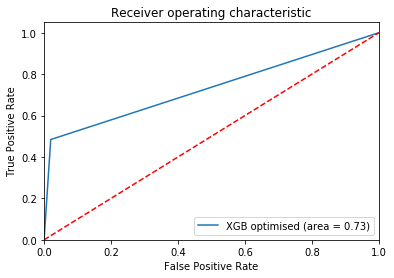

0.4842249657064472
0.9398955671592045
[[8107  165]
 [ 376  353]]


In [113]:
xgb_final = XGBClassifier(class_weight='balanced',n_jobs=10,max_depth=6)

xgb_final.fit(X_train,y_train)
y_pred = xgb_final.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='XGB optimised (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

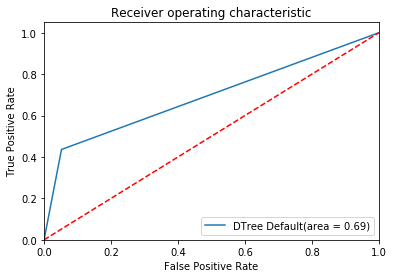

0.43621399176954734
0.906565937118098
[[7842  430]
 [ 411  318]]


In [114]:
dtree = DecisionTreeClassifier(class_weight='balanced')
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='DTree Default(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

In [115]:
dtree = DecisionTreeClassifier(class_weight='balanced')

params = [{'criterion' : ['gini','entropy']},
          {'max_depth':range(3,50,1)},
          {'min_samples_split' : range(10,100,2)},
          {'min_samples_leaf':range(5,100,5)},
          {'max_features':['auto','sqrt','log2']},
          {'max_leaf_nodes':range(20,100,5)}]

dtree_gs = GridSearchCV(dtree,params,cv=5,scoring='recall',return_train_score=True,n_jobs=10)
dtree_gs.fit(X_train,y_train)
print(dtree_gs.best_score_)
print(dtree_gs.best_params_)

0.828847222932615
{'max_leaf_nodes': 30}


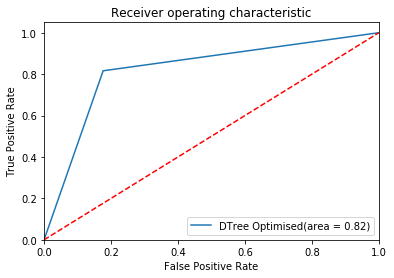

0.8161865569272977
0.8230196644817243
[[6813 1459]
 [ 134  595]]


In [118]:
dtree_final = DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=30)
dtree_final.fit(X_train,y_train)
y_pred = dtree_final.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='DTree Optimised(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(metrics.recall_score(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

In [119]:
imp_features = dtree_final.feature_importances_
X.iloc[:,sorted(range(len(imp_features)), key=lambda i: imp_features[i])[-10:]].columns

Index(['loc_ic_t2t_mou_delta2', 'roam_ic_mou_delta2', 'loc_og_t2t_mou_delta2',
       'arpu_delta2', 'loc_ic_mou_6', 'roam_og_mou_delta2',
       'std_og_mou_delta2', 'days_8_flag_woe', 'fb_user_8_woe',
       'total_ic_mou_delta2'],
      dtype='object')

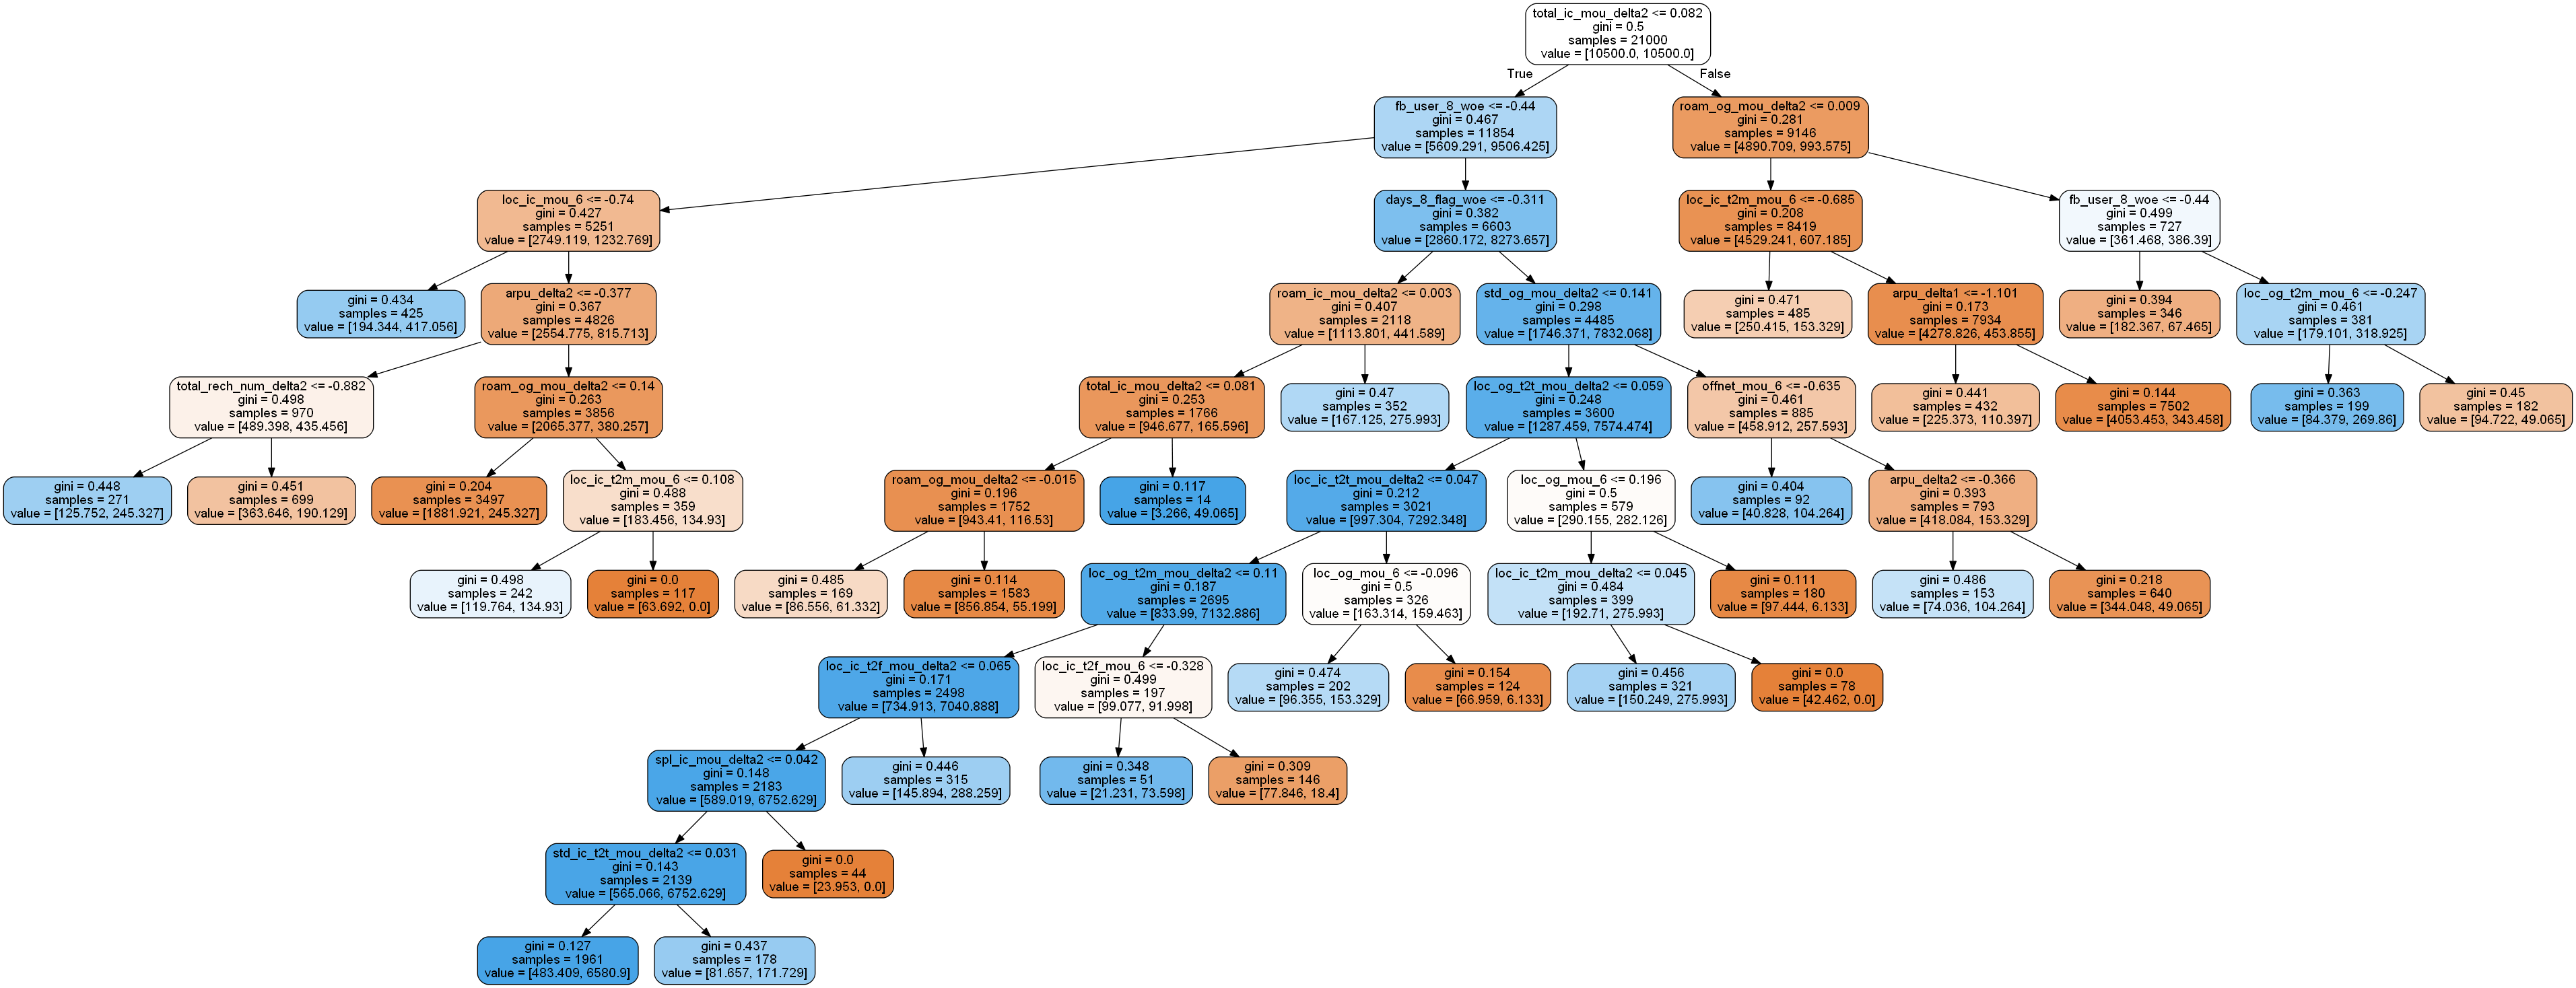

In [124]:
dot_data = StringIO()  
features = X.columns
export_graphviz(dtree_final, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

#### Model - Sensitivity / ROC / Accuracy
#### LR - 0.79/0.81/0.82 (PCA)

#### RFC = 0.33/0.66/0.93 (Default)
#### RFC - GS = 0.78/0.81/0.82 (Default)

#### XGB = 0.45/0.72/0.93 (Default)
#### XGB - GS = 0.48/0.73/0.93 (Default)

#### DT = 0.43/0.69/0.91
#### DT - GS = 0.82/0.82/0.82 (Default) 

## Top models are Decision Tree Classifier & Random Forest Classifier because sensitivity is high with best ROC & Accuracy.